In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pickle
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import copy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings(action='ignore')
from epftoolbox.evaluation import MAE, sMAPE

C:\Users\UX431\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# DNN

In [2]:
df = pd.read_csv("Data\EPFToolbox\BE.csv")
# df['Date'] = pd.to_datetime(df.Date)

In [3]:
df['Date'] = pd.to_datetime(df.Date)
df['Simple Date'] = df.Date.dt.strftime("%Y-%m-%d")
df['Hour'] = df.Date.dt.hour

In [4]:
df.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']

In [5]:
df

,Date,Price,Exogenous 1,Exogenous 2,Simple Date,Hour
0,2011-01-09 00:00:00,32.54,63065.0,63000.0,2011-01-09,0
1,2011-01-09 01:00:00,21.55,62715.0,58800.0,2011-01-09,1
2,2011-01-09 02:00:00,15.71,61952.0,58500.0,2011-01-09,2
3,2011-01-09 03:00:00,10.58,59262.0,54300.0,2011-01-09,3
4,2011-01-09 04:00:00,10.32,56883.0,51900.0,2011-01-09,4
...,...,...,...,...,...,...
52411,2016-12-31 19:00:00,40.84,70329.0,73957.0,2016-12-31,19
52412,2016-12-31 20:00:00,40.10,69121.0,72544.0,2016-12-31,20
52413,2016-12-31 21:00:00,36.00,66647.0,69451.0,2016-12-31,21
52414,2016-12-31 22:00:00,35.00,65886.0,67823.0,2016-12-31,22


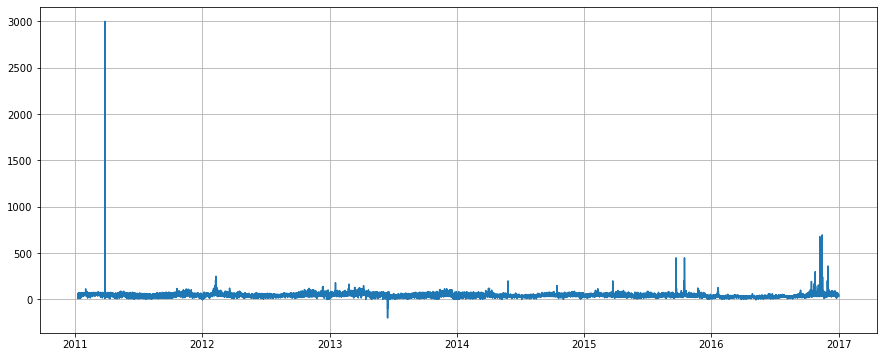

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(df.Date, df.Price)
ax.grid()

In [7]:
df['Price_no_outliers'] = df.Price

Se añaden variables auxiliares

In [8]:
df['Price_24'] = df.Price.shift(24)
df['Price_48'] = df.Price.shift(48)
df['Price_72'] = df.Price.shift(72)
df['Price_96'] = df.Price.shift(96)
df['Price_120'] = df.Price.shift(120)
df['Price_144'] = df.Price.shift(144)
df['Price_168'] = df.Price.shift(168)

In [9]:
df["diff_Price_24"] = df.Price - df.Price_24
df["lower_quantile_diff_Price_24"] = np.nan
df["upper_quantile_diff_Price_24"] = np.nan
for idx in range(len(df)):
    if idx >= 168:
        df_aux = df.loc[idx - 168 : idx - 1]
        df.loc[idx, "lower_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.025
        )
        df.loc[idx, "upper_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.975
        )

df["outlier"] = 0
df.loc[
    (df.diff_Price_24 < df.lower_quantile_diff_Price_24)
    | (df.diff_Price_24 > df.upper_quantile_diff_Price_24),
    "outlier",
] = 1

# df["Price_no_outliers"] = df["Price"]
col = df.loc[
    :,
    [
        "Price_24",
        "Price_48",
        "Price_72",
        "Price_96",
        "Price_120",
        "Price_144",
        "Price_168",
    ],
]
df["Price_median"] = col.median(axis=1)
df.loc[df.outlier == 1, "Price_no_outliers"] = df[
    df.outlier == 1
].Price_median

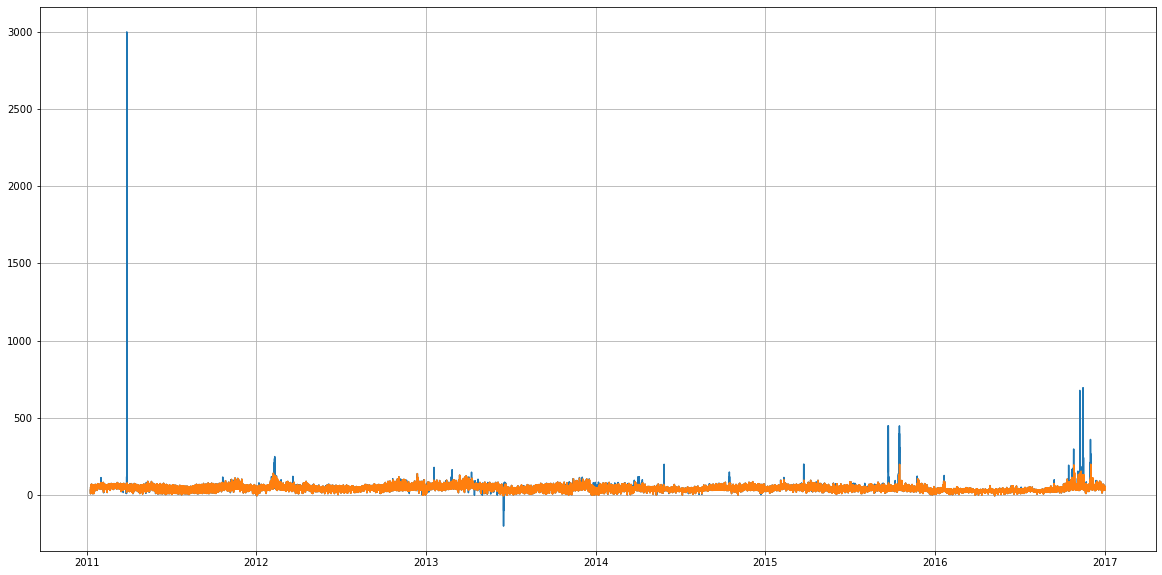

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(df.Date, df.Price)
ax.plot(df.Date, df.Price_no_outliers)
ax.grid()

In [11]:
df = df[['Date', 'Price_no_outliers', 'Exogenous 1', 'Exogenous 2']].rename(columns={'Price_no_outliers':'Price'})

In [12]:
df.index = df.Date

In [13]:
df = df.drop(['Date'], axis = 1)

In [14]:
df.columns = ['Price', 'Exogenous 1', 'Exogenous 2']

In [15]:
df_train = df[df.index < dt.datetime(2015, 1, 1)]
df_test = df[df.index >= dt.datetime(2015, 1, 1)]

In [16]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [17]:
forecast_dates = forecast.index

In [18]:
df_original = pd.read_csv(r"Data\EPFToolbox\BE.csv")

In [19]:
df_original['Date'] = pd.to_datetime(df_original.Date)

In [20]:
df_original.index = df_original.Date

In [21]:
df_original = df_original.drop('Date', axis = 1)

In [22]:
df_original.columns = ['Price', 'Exogenous 1', 'Exogenous 2']

In [23]:
df_original = df_original[df_original.index >= dt.datetime(2015, 1, 1)]

In [24]:
real_values = df_original[df_original.index >= dt.datetime(2015, 1, 1)].loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [25]:
real_values

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,53.48,51.93,48.76,42.27,38.41,35.72,32.66,32.83,30.06,29.24,...,33.29,32.47,34.73,40.95,51.25,52.55,49.55,46.31,48.75,47.59
2015-01-02,38.80,36.73,33.52,27.50,22.84,26.10,27.17,33.33,42.06,46.13,...,41.00,39.78,39.73,50.24,54.10,53.13,48.81,42.99,48.76,48.45
2015-01-03,46.97,43.27,41.76,37.54,32.99,31.24,36.71,39.47,44.51,44.45,...,42.44,39.94,42.44,53.10,49.82,47.62,43.79,42.44,42.03,40.91
2015-01-04,36.26,32.28,27.63,27.03,27.04,27.19,27.13,27.06,27.63,34.54,...,37.00,36.87,40.00,53.10,54.35,51.57,49.99,41.18,44.79,42.96
2015-01-05,36.56,34.94,32.19,28.05,28.04,34.26,44.28,50.38,53.79,52.03,...,42.00,43.10,46.70,56.78,58.84,53.60,46.90,44.58,48.70,46.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,35.30,38.33,41.04,34.62,29.69,28.35,30.99,42.08,45.27,46.56,...,51.27,51.82,65.19,69.99,72.89,72.15,52.07,44.00,56.41,63.25
2016-12-28,37.12,36.03,34.15,36.03,33.95,34.82,43.70,51.00,53.00,57.34,...,50.77,51.60,55.20,63.29,63.70,59.82,61.20,50.00,43.18,43.77
2016-12-29,42.28,39.30,36.83,34.11,34.99,37.64,41.05,49.30,53.30,53.93,...,49.60,51.63,54.43,63.95,64.35,56.72,48.50,45.66,46.94,44.08


In [26]:
from epftoolbox.models import hyperparameter_optimizer

In [27]:
df.to_csv("Data/EPFToolbox/BE_dnn_no_outliers.csv")

In [28]:
# Number of layers in DNN
nlayers = 2

# Market under study. If it not one of the standard ones, the file name
# has to be provided, where the file has to be a csv file
dataset = "BE_dnn_no_outliers"

# Number of years (a year is 364 days) in the test dataset.
years_test = 2

# Optional parameters for selecting the test dataset, if either of them is not provided, 
# the test dataset is built using the years_test parameter. They should either be one of
# the date formats existing in python or a string with the following format
# "%d/%m/%Y %H:%M"
begin_test_date = "01/01/2015 00:00"
end_test_date = "31/12/2016 23:00"

# Boolean that selects whether the validation and training datasets are shuffled
shuffle_train = 1

# Boolean that selects whether a data augmentation technique for DNNs is used
data_augmentation = 0

# Boolean that selects whether we start a new hyperparameter optimization or we restart an existing one
new_hyperopt = 1

# Number of years used in the training dataset for recalibration
calibration_window = 4

# Unique identifier to read the trials file of hyperparameter optimization
experiment_id = 1

# Number of iterations for hyperparameter optimization
max_evals = 100

path_datasets_folder = "./Data/EPFToolbox/"
path_hyperparameters_folder = "./experimental_files/"

# Check documentation of the hyperparameter_optimizer for each of the function parameters
# In this example, we optimize a model for the PJM market.
# We consider two directories, one for storing the datasets and the other one for the experimental files.
# We start a hyperparameter optimization from scratch. We employ 1500 iterations in hyperopt,
# 2 years of test data, a DNN with 2 hidden layers, a calibration window of 4 years,
# we avoid data augmentation,  and we provide an experiment_id equal to 1
hyperparameter_optimizer(path_datasets_folder=path_datasets_folder, 
                         path_hyperparameters_folder=path_hyperparameters_folder, 
                         new_hyperopt=new_hyperopt, max_evals=max_evals, nlayers=nlayers, dataset=dataset, 
                         years_test=years_test, calibration_window=calibration_window, 
                         shuffle_train=shuffle_train, data_augmentation=0, experiment_id=experiment_id,
                         begin_test_date=begin_test_date, end_test_date=end_test_date)

Test datasets: 2015-01-01 00:00:00 - 2016-12-31 23:00:00


Tested 1/100 iterations.
Best MAE - Validation Dataset
  MAE: 21.3 | sMAPE: 52.81 %

Best MAE - Test Dataset
  MAE: 33.7 | sMAPE: 99.87 %


Tested 2/100 iterations.
Best MAE - Validation Dataset
  MAE: 21.3 | sMAPE: 52.81 %

Best MAE - Test Dataset
  MAE: 33.7 | sMAPE: 99.87 %


Tested 3/100 iterations.
Best MAE - Validation Dataset
  MAE: 8.6 | sMAPE: 19.68 %

Best MAE - Test Dataset
  MAE: 12.3 | sMAPE: 31.18 %


Tested 4/100 iterations.
Best MAE - Validation Dataset
  MAE: 6.4 | sMAPE: 15.10 %

Best MAE - Test Dataset
  MAE: 8.2 | sMAPE: 21.54 %


Tested 5/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.3 | sMAPE: 12.43 %

Best MAE - Test Dataset
  MAE: 6.3 | sMAPE: 16.66 %


Tested 6/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.3 | sMAPE: 12.43 %

Best MAE - Test Dataset
  MAE: 6.3 | sMAPE: 16.66 %


Tested 7/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.3 | sMAPE: 12.43 %

Best MAE - Test Dataset




Tested 60/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.0 | sMAPE: 11.90 %

Best MAE - Test Dataset
  MAE: 5.8 | sMAPE: 15.36 %


Tested 61/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.0 | sMAPE: 11.90 %

Best MAE - Test Dataset
  MAE: 5.8 | sMAPE: 15.36 %


Tested 62/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.0 | sMAPE: 11.90 %

Best MAE - Test Dataset
  MAE: 5.8 | sMAPE: 15.36 %


Tested 63/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.0 | sMAPE: 11.90 %

Best MAE - Test Dataset
  MAE: 5.8 | sMAPE: 15.36 %


Tested 64/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.0 | sMAPE: 11.90 %

Best MAE - Test Dataset
  MAE: 5.8 | sMAPE: 15.36 %


Tested 65/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.0 | sMAPE: 11.90 %

Best MAE - Test Dataset
  MAE: 5.8 | sMAPE: 15.36 %


Tested 66/100 iterations.
Best MAE - Validation Dataset
  MAE: 5.0 | sMAPE: 11.90 %

Best MAE - Test Dataset
  MAE: 5.8 | sMAPE: 15.36 %


Tested 67/100 iterations.

In [28]:
"""
Example for using the DNN model for forecasting prices with daily recalibration
"""

# Author: Jesus Lago

# License: AGPL-3.0 License

import pandas as pd
import numpy as np
import argparse
import os

from epftoolbox.data import read_data
from epftoolbox.evaluation import MAE, sMAPE
from epftoolbox.models import DNN


path_datasets_folder = "./Data/EPFToolbox/"
path_hyperparameters_folder = "./experimental_files/"
path_recalibration_folder = os.path.join('.', 'Resultados')
path_hyperparameter_folder = os.path.join('.', 'experimental_files')

dataset = "BE_dnn_no_outliers"

# Number of years (a year is 364 days) in the test dataset.
years_test = 2

# Optional parameters for selecting the test dataset, if either of them is not provided, 
# the test dataset is built using the years_test parameter. They should either be one of
# the date formats existing in python or a string with the following format
# "%d/%m/%Y %H:%M"
begin_test_date = "01/01/2015 00:00"
end_test_date = "31/12/2016 23:00"

# Defining train and testing data
df_train, df_test = read_data(dataset=dataset, years_test=years_test, path=path_datasets_folder,
                              begin_test_date=begin_test_date, end_test_date=end_test_date)

# Defining unique name to save the forecast
forecast_file_name = 'dnn_BE_no_outliers.csv'

forecast_file_path = os.path.join(path_recalibration_folder, forecast_file_name)

# # Defining empty forecast array and the real values to be predicted in a more friendly format
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_original[df_original.index >= dt.datetime(2015, 1, 1)].loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

# # If we are not starting a new recalibration but re-starting an old one, we import the
# # existing files and print metrics 
# if not new_recalibration:
#     # Import existinf forecasting file
#     forecast = pd.read_csv(forecast_file_path, index_col=0)
#     forecast.index = pd.to_datetime(forecast.index)

#     # Reading dates to still be forecasted by checking NaN values
#     forecast_dates = forecast[forecast.isna().any(axis=1)].index

#     # If all the dates to be forecasted have already been forecast, we print information
#     # and exit the script
#     if len(forecast_dates) == 0:

#         mae = np.mean(MAE(forecast.values.squeeze(), real_values.values))
#         smape = np.mean(sMAPE(forecast.values.squeeze(), real_values.values)) * 100
#         print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format('Final metrics', smape, mae))
    
# else:
#     forecast_dates = forecast.index

forecast_dates = forecast.index

nlayers = 2
shuffle_train = 1
data_augmentation = 0
calibration_window = 4
experiment_id = 1

model = DNN(
    experiment_id=experiment_id, path_hyperparameter_folder=path_hyperparameter_folder, nlayers=nlayers, 
    dataset=dataset, years_test=years_test, shuffle_train=shuffle_train, data_augmentation=data_augmentation,
    calibration_window=calibration_window)


# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We extract real prices for current date and set them to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date)

    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

#     # Saving forecast
#     forecast.to_csv(forecast_file_path)

Test datasets: 2015-01-01 00:00:00 - 2016-12-31 23:00:00
2015-01-01 - sMAPE: 9.85%  |  MAE: 3.950
2015-01-02 - sMAPE: 9.19%  |  MAE: 3.527
2015-01-03 - sMAPE: 8.31%  |  MAE: 3.264
2015-01-04 - sMAPE: 8.33%  |  MAE: 3.263
2015-01-05 - sMAPE: 8.27%  |  MAE: 3.367
2015-01-06 - sMAPE: 8.47%  |  MAE: 3.591
2015-01-07 - sMAPE: 7.94%  |  MAE: 3.399
2015-01-08 - sMAPE: 7.68%  |  MAE: 3.275
2015-01-09 - sMAPE: 8.69%  |  MAE: 3.627
2015-01-10 - sMAPE: 9.67%  |  MAE: 3.898
2015-01-11 - sMAPE: 9.85%  |  MAE: 3.827
2015-01-12 - sMAPE: 10.17%  |  MAE: 3.953
2015-01-13 - sMAPE: 10.22%  |  MAE: 3.979
2015-01-14 - sMAPE: 9.87%  |  MAE: 3.857
2015-01-15 - sMAPE: 10.17%  |  MAE: 3.980
2015-01-16 - sMAPE: 9.95%  |  MAE: 3.902
2015-01-17 - sMAPE: 9.84%  |  MAE: 3.855
2015-01-18 - sMAPE: 9.59%  |  MAE: 3.760
2015-01-19 - sMAPE: 9.39%  |  MAE: 3.710
2015-01-20 - sMAPE: 9.12%  |  MAE: 3.621
2015-01-21 - sMAPE: 9.00%  |  MAE: 3.596
2015-01-22 - sMAPE: 8.83%  |  MAE: 3.550
2015-01-23 - sMAPE: 8.76%  |  MAE: 3.5

2015-07-16 - sMAPE: 14.33%  |  MAE: 6.273
2015-07-17 - sMAPE: 14.30%  |  MAE: 6.258
2015-07-18 - sMAPE: 14.27%  |  MAE: 6.244
2015-07-19 - sMAPE: 14.27%  |  MAE: 6.239
2015-07-20 - sMAPE: 14.26%  |  MAE: 6.235
2015-07-21 - sMAPE: 14.25%  |  MAE: 6.233
2015-07-22 - sMAPE: 14.21%  |  MAE: 6.215
2015-07-23 - sMAPE: 14.18%  |  MAE: 6.204
2015-07-24 - sMAPE: 14.13%  |  MAE: 6.186
2015-07-25 - sMAPE: 14.26%  |  MAE: 6.216
2015-07-26 - sMAPE: 14.32%  |  MAE: 6.218
2015-07-27 - sMAPE: 14.38%  |  MAE: 6.231
2015-07-28 - sMAPE: 14.40%  |  MAE: 6.229
2015-07-29 - sMAPE: 14.40%  |  MAE: 6.222
2015-07-30 - sMAPE: 14.40%  |  MAE: 6.217
2015-07-31 - sMAPE: 14.41%  |  MAE: 6.215
2015-08-01 - sMAPE: 14.40%  |  MAE: 6.206
2015-08-02 - sMAPE: 14.45%  |  MAE: 6.216
2015-08-03 - sMAPE: 14.47%  |  MAE: 6.218
2015-08-04 - sMAPE: 14.48%  |  MAE: 6.220
2015-08-05 - sMAPE: 14.46%  |  MAE: 6.207
2015-08-06 - sMAPE: 14.44%  |  MAE: 6.197
2015-08-07 - sMAPE: 14.40%  |  MAE: 6.181
2015-08-08 - sMAPE: 14.39%  |  MAE

2016-01-28 - sMAPE: 15.07%  |  MAE: 6.973
2016-01-29 - sMAPE: 15.05%  |  MAE: 6.963
2016-01-30 - sMAPE: 15.04%  |  MAE: 6.949
2016-01-31 - sMAPE: 15.07%  |  MAE: 6.942
2016-02-01 - sMAPE: 15.08%  |  MAE: 6.937
2016-02-02 - sMAPE: 15.09%  |  MAE: 6.926
2016-02-03 - sMAPE: 15.11%  |  MAE: 6.924
2016-02-04 - sMAPE: 15.10%  |  MAE: 6.915
2016-02-05 - sMAPE: 15.09%  |  MAE: 6.906
2016-02-06 - sMAPE: 15.11%  |  MAE: 6.901
2016-02-07 - sMAPE: 15.11%  |  MAE: 6.888
2016-02-08 - sMAPE: 15.12%  |  MAE: 6.878
2016-02-09 - sMAPE: 15.10%  |  MAE: 6.866
2016-02-10 - sMAPE: 15.09%  |  MAE: 6.855
2016-02-11 - sMAPE: 15.06%  |  MAE: 6.843
2016-02-12 - sMAPE: 15.05%  |  MAE: 6.833
2016-02-13 - sMAPE: 15.05%  |  MAE: 6.823
2016-02-14 - sMAPE: 15.07%  |  MAE: 6.816
2016-02-15 - sMAPE: 15.08%  |  MAE: 6.813
2016-02-16 - sMAPE: 15.07%  |  MAE: 6.805
2016-02-17 - sMAPE: 15.05%  |  MAE: 6.795
2016-02-18 - sMAPE: 15.04%  |  MAE: 6.785
2016-02-19 - sMAPE: 15.04%  |  MAE: 6.781
2016-02-20 - sMAPE: 15.04%  |  MAE

2016-08-11 - sMAPE: 14.32%  |  MAE: 5.689
2016-08-12 - sMAPE: 14.31%  |  MAE: 5.683
2016-08-13 - sMAPE: 14.31%  |  MAE: 5.678
2016-08-14 - sMAPE: 14.33%  |  MAE: 5.677
2016-08-15 - sMAPE: 14.32%  |  MAE: 5.671
2016-08-16 - sMAPE: 14.31%  |  MAE: 5.665
2016-08-17 - sMAPE: 14.30%  |  MAE: 5.660
2016-08-18 - sMAPE: 14.30%  |  MAE: 5.658
2016-08-19 - sMAPE: 14.30%  |  MAE: 5.654
2016-08-20 - sMAPE: 14.28%  |  MAE: 5.648
2016-08-21 - sMAPE: 14.31%  |  MAE: 5.645
2016-08-22 - sMAPE: 14.30%  |  MAE: 5.640
2016-08-23 - sMAPE: 14.28%  |  MAE: 5.634
2016-08-24 - sMAPE: 14.27%  |  MAE: 5.630
2016-08-25 - sMAPE: 14.27%  |  MAE: 5.626
2016-08-26 - sMAPE: 14.25%  |  MAE: 5.620
2016-08-27 - sMAPE: 14.25%  |  MAE: 5.616
2016-08-28 - sMAPE: 14.25%  |  MAE: 5.611
2016-08-29 - sMAPE: 14.26%  |  MAE: 5.616
2016-08-30 - sMAPE: 14.27%  |  MAE: 5.617
2016-08-31 - sMAPE: 14.27%  |  MAE: 5.615
2016-09-01 - sMAPE: 14.26%  |  MAE: 5.609
2016-09-02 - sMAPE: 14.27%  |  MAE: 5.611
2016-09-03 - sMAPE: 14.27%  |  MAE

In [29]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,46.393661,41.137962,38.166073,34.962276,31.89959,30.794134,28.237036,27.518847,29.860218,35.354897,...,35.779732,34.063217,36.164555,47.540138,56.470177,56.410519,52.72578,48.217648,49.319244,46.963219
2015-01-02,42.583534,39.069798,36.630375,32.991249,30.88171,32.119904,32.840042,35.173023,37.365227,40.691444,...,38.839451,37.178539,39.013966,47.634811,54.110371,53.669971,50.487221,45.631062,47.402943,43.951744
2015-01-03,40.825008,37.807064,35.542732,32.61631,31.112652,32.30722,34.027889,37.933716,40.412865,43.663586,...,40.250313,38.823116,40.061657,48.081917,53.061199,51.575974,47.63467,43.567177,45.341431,42.205063
2015-01-04,36.825306,33.484798,31.14048,27.778782,26.103285,26.576004,26.099924,27.305876,29.472864,33.436977,...,31.711548,30.394705,32.374851,40.975395,47.608738,47.527439,43.93504,39.971142,41.922642,38.829601
2015-01-05,40.054714,37.494606,34.784004,30.952473,29.961533,34.112049,42.177643,50.081898,52.527325,53.674015,...,51.162235,50.011993,52.041855,62.259674,65.534775,58.80547,53.32185,47.694828,48.125683,45.040119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,35.665077,31.993456,29.300863,26.510359,26.075348,30.234278,41.516026,52.80542,55.312962,55.924053,...,50.938595,50.046143,50.885441,57.846699,61.855732,60.084545,54.862453,47.458359,48.396294,45.619995
2016-12-28,44.711605,42.026775,39.658688,36.046745,35.412113,38.573792,46.476429,55.448505,58.18578,58.528278,...,53.513401,52.47411,53.74884,63.794445,68.974686,64.195862,56.434288,49.418056,51.089378,49.687405
2016-12-29,38.268764,36.464382,34.072613,31.357903,30.574301,34.87957,43.311337,54.661354,56.613121,57.405891,...,52.289097,52.080002,53.957859,64.406433,67.556152,59.948574,53.129337,46.455822,47.893768,46.099689


In [30]:
forecast.to_csv("Resultados/dnn_BE_final_no_outliers.csv")

# DNN + Estandarización móvil

In [2]:
with open('dict_new_df_be_epftoolbox_final_no_outliers.pkl', 'rb') as handle:
    dict_new_df = pickle.load(handle)

In [3]:
df_nuevo = pd.DataFrame(dict_new_df)

In [4]:
df_nuevo['Date'] = pd.to_datetime(df_nuevo.Date)

In [5]:
df_scalers = pd.DataFrame({'Date':dict_new_df['Date'], 'scaler':dict_new_df['scaler']})

In [6]:
df_scalers

,Date,scaler
0,2011-01-16 00:00:00,StandardScaler()
1,2011-01-16 01:00:00,StandardScaler()
2,2011-01-16 02:00:00,StandardScaler()
3,2011-01-16 03:00:00,StandardScaler()
4,2011-01-16 04:00:00,StandardScaler()
...,...,...
52243,2016-12-31 19:00:00,StandardScaler()
52244,2016-12-31 20:00:00,StandardScaler()
52245,2016-12-31 21:00:00,StandardScaler()
52246,2016-12-31 22:00:00,StandardScaler()


In [7]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'serif'

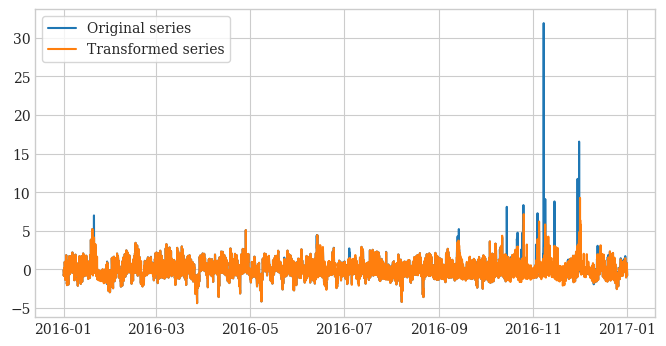

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(df_nuevo[df_nuevo.Date >= dt.datetime(2016, 1, 1)].Date, df_nuevo[df_nuevo.Date >= dt.datetime(2016, 1, 1)].Price, label='Original series')
ax.plot(df_nuevo[df_nuevo.Date >= dt.datetime(2016, 1, 1)].Date, df_nuevo[df_nuevo.Date >= dt.datetime(2016, 1, 1)].Price_no_outliers, label='Transformed series')
ax.legend(prop={'size':10})
ax.legend(frameon=True)
# ax.title.set_text("MAE by month OMIE-SP")
# ax.title.set_size(14)
# fig.autofmt_xdate(rotation=45)

In [12]:
fig.savefig("no_outlier_series.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [7]:
df_nuevo = df_nuevo[['Date', 'Price_no_outliers', 'Exogenous 1', 'Exogenous 2']]

In [10]:
df_nuevo.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2']

In [11]:
df_nuevo = df_nuevo.set_index('Date')

In [12]:
df_nuevo.to_csv("Data/EPFToolbox/BE_dnn_estandarizacion_movil_no_outliers.csv")

In [13]:
from epftoolbox.models import hyperparameter_optimizer

In [14]:
# Number of layers in DNN
nlayers = 2

# Market under study. If it not one of the standard ones, the file name
# has to be provided, where the file has to be a csv file
dataset = "BE_dnn_estandarizacion_movil_no_outliers"

# Number of years (a year is 364 days) in the test dataset.
years_test = 1.5

# Optional parameters for selecting the test dataset, if either of them is not provided, 
# the test dataset is built using the years_test parameter. They should either be one of
# the date formats existing in python or a string with the following format
# "%d/%m/%Y %H:%M"
begin_test_date = "01/01/2015 00:00"
end_test_date = "31/12/2016 23:00"

# Boolean that selects whether the validation and training datasets are shuffled
shuffle_train = 1

# Boolean that selects whether a data augmentation technique for DNNs is used
data_augmentation = 0

# Boolean that selects whether we start a new hyperparameter optimization or we restart an existing one
new_hyperopt = 1

# Number of years used in the training dataset for recalibration
calibration_window = None

# Unique identifier to read the trials file of hyperparameter optimization
experiment_id = 2

# Number of iterations for hyperparameter optimization
max_evals = 100

path_datasets_folder = "./Data/EPFToolbox/"
path_hyperparameters_folder = "./experimental_files/"

# Check documentation of the hyperparameter_optimizer for each of the function parameters
# In this example, we optimize a model for the PJM market.
# We consider two directories, one for storing the datasets and the other one for the experimental files.
# We start a hyperparameter optimization from scratch. We employ 1500 iterations in hyperopt,
# 2 years of test data, a DNN with 2 hidden layers, a calibration window of 4 years,
# we avoid data augmentation,  and we provide an experiment_id equal to 1
hyperparameter_optimizer(path_datasets_folder=path_datasets_folder, 
                         path_hyperparameters_folder=path_hyperparameters_folder, 
                         new_hyperopt=new_hyperopt, max_evals=max_evals, nlayers=nlayers, dataset=dataset, 
                         years_test=years_test, calibration_window=calibration_window, 
                         shuffle_train=shuffle_train, data_augmentation=0, experiment_id=experiment_id,
                         begin_test_date=begin_test_date, end_test_date=end_test_date)

Test datasets: 2015-01-01 00:00:00 - 2016-12-31 23:00:00


Tested 1/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.6 | sMAPE: 97.57 %

Best MAE - Test Dataset
  MAE: 0.7 | sMAPE: 106.40 %


Tested 2/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 72.19 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 82.77 %


Tested 3/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 72.19 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 82.77 %


Tested 4/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 73.64 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 82.93 %


Tested 5/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 73.64 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 82.93 %


Tested 6/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 73.64 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 82.93 %


Tested 7/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 73.64 %

Best MAE - Test Dataset
  MA



Tested 60/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 69.27 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 78.99 %


Tested 61/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 69.27 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 78.99 %


Tested 62/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 68.63 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 78.51 %


Tested 63/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 68.63 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 78.51 %


Tested 64/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 68.63 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 78.51 %


Tested 65/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 68.63 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 78.51 %


Tested 66/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 68.63 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 78.51 %


Tested 67/100 iterations.

In [15]:
"""
Example for using the DNN model for forecasting prices with daily recalibration
"""

# Author: Jesus Lago

# License: AGPL-3.0 License

import pandas as pd
import numpy as np
import argparse
import os

from epftoolbox.data import read_data
from epftoolbox.evaluation import MAE, sMAPE
from epftoolbox.models import DNN


path_datasets_folder = "./Data/EPFToolbox/"
path_hyperparameters_folder = "./experimental_files/"
path_recalibration_folder = os.path.join('.', 'Resultados')
path_hyperparameter_folder = os.path.join('.', 'experimental_files')

dataset = "BE_dnn_estandarizacion_movil_no_outliers"

# Number of years (a year is 364 days) in the test dataset.
years_test = 1.5

# Optional parameters for selecting the test dataset, if either of them is not provided, 
# the test dataset is built using the years_test parameter. They should either be one of
# the date formats existing in python or a string with the following format
# "%d/%m/%Y %H:%M"
begin_test_date = "01/01/2015 00:00"
end_test_date = "31/12/2016 23:00"

# Defining train and testing data
df_train, df_test = read_data(dataset=dataset, years_test=years_test, path=path_datasets_folder,
                              begin_test_date=begin_test_date, end_test_date=end_test_date)

# Defining unique name to save the forecast
forecast_file_name = 'dnn_BE_estandarizacion_movil_final_no_outliers.csv'

forecast_file_path = os.path.join(path_recalibration_folder, forecast_file_name)

# # Defining empty forecast array and the real values to be predicted in a more friendly format
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

# # If we are not starting a new recalibration but re-starting an old one, we import the
# # existing files and print metrics 
# if not new_recalibration:
#     # Import existinf forecasting file
#     forecast = pd.read_csv(forecast_file_path, index_col=0)
#     forecast.index = pd.to_datetime(forecast.index)

#     # Reading dates to still be forecasted by checking NaN values
#     forecast_dates = forecast[forecast.isna().any(axis=1)].index

#     # If all the dates to be forecasted have already been forecast, we print information
#     # and exit the script
#     if len(forecast_dates) == 0:

#         mae = np.mean(MAE(forecast.values.squeeze(), real_values.values))
#         smape = np.mean(sMAPE(forecast.values.squeeze(), real_values.values)) * 100
#         print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format('Final metrics', smape, mae))
    
# else:
#     forecast_dates = forecast.index

forecast_dates = forecast.index

nlayers = 2
shuffle_train = 1
data_augmentation = 0
calibration_window = None
experiment_id = 2

model = DNN(
    experiment_id=experiment_id, path_hyperparameter_folder=path_hyperparameter_folder, nlayers=nlayers, 
    dataset=dataset, years_test=years_test, shuffle_train=shuffle_train, data_augmentation=data_augmentation,
    calibration_window=calibration_window)


# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We extract real prices for current date and set them to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date)

    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

#     # Saving forecast
#     forecast.to_csv(forecast_file_path)

Test datasets: 2015-01-01 00:00:00 - 2016-12-31 23:00:00
2015-01-01 - sMAPE: 73.20%  |  MAE: 0.367
2015-01-02 - sMAPE: 81.20%  |  MAE: 0.382
2015-01-03 - sMAPE: 95.45%  |  MAE: 0.387
2015-01-04 - sMAPE: 89.14%  |  MAE: 0.389
2015-01-05 - sMAPE: 83.21%  |  MAE: 0.372
2015-01-06 - sMAPE: 78.55%  |  MAE: 0.353
2015-01-07 - sMAPE: 74.73%  |  MAE: 0.342
2015-01-08 - sMAPE: 73.27%  |  MAE: 0.340
2015-01-09 - sMAPE: 78.94%  |  MAE: 0.386
2015-01-10 - sMAPE: 79.01%  |  MAE: 0.423
2015-01-11 - sMAPE: 78.51%  |  MAE: 0.434
2015-01-12 - sMAPE: 77.18%  |  MAE: 0.416
2015-01-13 - sMAPE: 76.06%  |  MAE: 0.418
2015-01-14 - sMAPE: 75.03%  |  MAE: 0.408
2015-01-15 - sMAPE: 74.93%  |  MAE: 0.420
2015-01-16 - sMAPE: 74.35%  |  MAE: 0.417
2015-01-17 - sMAPE: 75.81%  |  MAE: 0.409
2015-01-18 - sMAPE: 76.99%  |  MAE: 0.409
2015-01-19 - sMAPE: 75.04%  |  MAE: 0.403
2015-01-20 - sMAPE: 73.09%  |  MAE: 0.395
2015-01-21 - sMAPE: 72.58%  |  MAE: 0.390
2015-01-22 - sMAPE: 71.53%  |  MAE: 0.386
2015-01-23 - sMAPE:

2015-07-14 - sMAPE: 84.53%  |  MAE: 0.487
2015-07-15 - sMAPE: 84.50%  |  MAE: 0.488
2015-07-16 - sMAPE: 84.39%  |  MAE: 0.488
2015-07-17 - sMAPE: 84.22%  |  MAE: 0.487
2015-07-18 - sMAPE: 84.34%  |  MAE: 0.486
2015-07-19 - sMAPE: 84.42%  |  MAE: 0.487
2015-07-20 - sMAPE: 84.30%  |  MAE: 0.486
2015-07-21 - sMAPE: 84.24%  |  MAE: 0.487
2015-07-22 - sMAPE: 84.08%  |  MAE: 0.486
2015-07-23 - sMAPE: 83.87%  |  MAE: 0.485
2015-07-24 - sMAPE: 83.87%  |  MAE: 0.485
2015-07-25 - sMAPE: 84.02%  |  MAE: 0.487
2015-07-26 - sMAPE: 83.87%  |  MAE: 0.487
2015-07-27 - sMAPE: 84.05%  |  MAE: 0.488
2015-07-28 - sMAPE: 84.35%  |  MAE: 0.490
2015-07-29 - sMAPE: 84.63%  |  MAE: 0.491
2015-07-30 - sMAPE: 84.80%  |  MAE: 0.491
2015-07-31 - sMAPE: 84.71%  |  MAE: 0.491
2015-08-01 - sMAPE: 84.86%  |  MAE: 0.490
2015-08-02 - sMAPE: 84.87%  |  MAE: 0.491
2015-08-03 - sMAPE: 84.87%  |  MAE: 0.490
2015-08-04 - sMAPE: 84.85%  |  MAE: 0.491
2015-08-05 - sMAPE: 84.72%  |  MAE: 0.490
2015-08-06 - sMAPE: 84.57%  |  MAE

2016-01-26 - sMAPE: 84.44%  |  MAE: 0.494
2016-01-27 - sMAPE: 84.42%  |  MAE: 0.493
2016-01-28 - sMAPE: 84.42%  |  MAE: 0.493
2016-01-29 - sMAPE: 84.37%  |  MAE: 0.492
2016-01-30 - sMAPE: 84.31%  |  MAE: 0.492
2016-01-31 - sMAPE: 84.22%  |  MAE: 0.492
2016-02-01 - sMAPE: 84.21%  |  MAE: 0.492
2016-02-02 - sMAPE: 84.19%  |  MAE: 0.492
2016-02-03 - sMAPE: 84.14%  |  MAE: 0.492
2016-02-04 - sMAPE: 84.03%  |  MAE: 0.491
2016-02-05 - sMAPE: 83.98%  |  MAE: 0.490
2016-02-06 - sMAPE: 84.00%  |  MAE: 0.490
2016-02-07 - sMAPE: 83.86%  |  MAE: 0.489
2016-02-08 - sMAPE: 83.79%  |  MAE: 0.489
2016-02-09 - sMAPE: 83.71%  |  MAE: 0.488
2016-02-10 - sMAPE: 83.62%  |  MAE: 0.488
2016-02-11 - sMAPE: 83.49%  |  MAE: 0.487
2016-02-12 - sMAPE: 83.42%  |  MAE: 0.486
2016-02-13 - sMAPE: 83.40%  |  MAE: 0.486
2016-02-14 - sMAPE: 83.31%  |  MAE: 0.485
2016-02-15 - sMAPE: 83.29%  |  MAE: 0.485
2016-02-16 - sMAPE: 83.26%  |  MAE: 0.485
2016-02-17 - sMAPE: 83.26%  |  MAE: 0.485
2016-02-18 - sMAPE: 83.13%  |  MAE

2016-08-09 - sMAPE: 79.40%  |  MAE: 0.458
2016-08-10 - sMAPE: 79.36%  |  MAE: 0.457
2016-08-11 - sMAPE: 79.32%  |  MAE: 0.457
2016-08-12 - sMAPE: 79.29%  |  MAE: 0.456
2016-08-13 - sMAPE: 79.27%  |  MAE: 0.456
2016-08-14 - sMAPE: 79.23%  |  MAE: 0.456
2016-08-15 - sMAPE: 79.19%  |  MAE: 0.456
2016-08-16 - sMAPE: 79.11%  |  MAE: 0.455
2016-08-17 - sMAPE: 79.11%  |  MAE: 0.455
2016-08-18 - sMAPE: 79.06%  |  MAE: 0.455
2016-08-19 - sMAPE: 79.01%  |  MAE: 0.455
2016-08-20 - sMAPE: 79.01%  |  MAE: 0.455
2016-08-21 - sMAPE: 79.01%  |  MAE: 0.456
2016-08-22 - sMAPE: 78.97%  |  MAE: 0.456
2016-08-23 - sMAPE: 78.92%  |  MAE: 0.456
2016-08-24 - sMAPE: 78.85%  |  MAE: 0.455
2016-08-25 - sMAPE: 78.79%  |  MAE: 0.455
2016-08-26 - sMAPE: 78.71%  |  MAE: 0.455
2016-08-27 - sMAPE: 78.72%  |  MAE: 0.454
2016-08-28 - sMAPE: 78.68%  |  MAE: 0.454
2016-08-29 - sMAPE: 78.69%  |  MAE: 0.455
2016-08-30 - sMAPE: 78.69%  |  MAE: 0.455
2016-08-31 - sMAPE: 78.67%  |  MAE: 0.455
2016-09-01 - sMAPE: 78.61%  |  MAE

In [16]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.446486,0.049852,-0.364564,-1.000382,-1.233509,-1.150601,-0.929431,-1.081868,-0.888618,-0.442177,...,-0.357384,-0.456185,-0.376551,0.254743,0.9543,0.843728,0.735268,0.33911,0.520487,0.333706
2015-01-02,-0.035015,-0.366151,-0.657616,-1.10931,-1.298441,-0.869298,-0.571673,-0.252116,-0.132185,0.192832,...,0.210289,-0.002115,0.0342,0.600654,1.378919,1.283279,0.777986,0.331146,0.446111,0.258336
2015-01-03,-0.302837,-0.558227,-0.984003,-1.53936,-1.67805,-1.295309,-0.931484,-0.41077,-0.121548,0.298971,...,0.069274,-0.035371,0.115365,0.892201,1.57592,0.939892,0.539506,0.071636,0.360639,0.143611
2015-01-04,-0.531452,-0.912512,-1.194964,-1.491415,-1.740402,-1.573474,-1.434399,-1.359834,-1.017088,-0.369667,...,-0.590394,-0.62911,-0.548979,0.225783,0.74298,0.791414,0.468778,0.028323,0.149956,0.001372
2015-01-05,-0.643415,-0.896053,-1.122112,-1.415275,-1.445922,-1.091778,-0.344318,0.500135,0.662555,0.951916,...,0.56623,0.56208,0.693889,1.468045,1.799175,1.510414,0.905267,0.356344,0.363215,0.124251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,-0.710606,-0.966578,-1.175817,-1.408644,-1.585883,-1.293305,-0.576612,0.042853,0.169145,0.295331,...,0.01148,0.092109,0.233786,0.790629,1.09365,0.72796,0.260899,-0.226695,-0.172347,-0.325557
2016-12-28,-0.236057,-0.412468,-0.682342,-0.973531,-1.06134,-0.84055,-0.325189,0.346531,0.413928,0.433026,...,0.272859,0.24163,0.480283,1.017691,1.369909,0.845355,0.224754,-0.207113,0.042869,0.015486
2016-12-29,-0.43779,-0.737657,-0.884609,-1.077974,-1.088295,-0.920354,-0.393115,0.291899,0.417277,0.465518,...,0.241911,0.3763,0.53285,1.556612,1.721581,1.139469,0.706165,0.211036,0.192631,-0.07848


In [17]:
forecast.to_csv("Resultados/dnn_BE_estandarizacion_movil_final_no_outliers.csv")

In [18]:
df_test_original = pd.DataFrame(forecast.values.reshape((-1,)), columns=['Price'])
df_test_original['Date'] = df_scalers.tail(len(df_test_original)).Date.to_numpy()

In [19]:
predicciones = np.array([])
for cont in range(0, len(df_test_original)):
    
    print(df_test_original.iloc[cont].Date)
    
    # Acumulamos las predicciones
    scaler_obj = df_scalers[df_scalers.Date == df_test_original.iloc[cont].Date].scaler.values[0]

    predicciones = np.append(predicciones, scaler_obj.inverse_transform(np.array(df_test_original.iloc[cont].Price).reshape(1, -1))[0][0])

2015-01-01 00:00:00
2015-01-01 01:00:00
2015-01-01 02:00:00
2015-01-01 03:00:00
2015-01-01 04:00:00
2015-01-01 05:00:00
2015-01-01 06:00:00
2015-01-01 07:00:00
2015-01-01 08:00:00
2015-01-01 09:00:00
2015-01-01 10:00:00
2015-01-01 11:00:00
2015-01-01 12:00:00
2015-01-01 13:00:00
2015-01-01 14:00:00
2015-01-01 15:00:00
2015-01-01 16:00:00
2015-01-01 17:00:00
2015-01-01 18:00:00
2015-01-01 19:00:00
2015-01-01 20:00:00
2015-01-01 21:00:00
2015-01-01 22:00:00
2015-01-01 23:00:00
2015-01-02 00:00:00
2015-01-02 01:00:00
2015-01-02 02:00:00
2015-01-02 03:00:00
2015-01-02 04:00:00
2015-01-02 05:00:00
2015-01-02 06:00:00
2015-01-02 07:00:00
2015-01-02 08:00:00
2015-01-02 09:00:00
2015-01-02 10:00:00
2015-01-02 11:00:00
2015-01-02 12:00:00
2015-01-02 13:00:00
2015-01-02 14:00:00
2015-01-02 15:00:00
2015-01-02 16:00:00
2015-01-02 17:00:00
2015-01-02 18:00:00
2015-01-02 19:00:00
2015-01-02 20:00:00
2015-01-02 21:00:00
2015-01-02 22:00:00
2015-01-02 23:00:00
2015-01-03 00:00:00
2015-01-03 01:00:00


2015-01-19 09:00:00
2015-01-19 10:00:00
2015-01-19 11:00:00
2015-01-19 12:00:00
2015-01-19 13:00:00
2015-01-19 14:00:00
2015-01-19 15:00:00
2015-01-19 16:00:00
2015-01-19 17:00:00
2015-01-19 18:00:00
2015-01-19 19:00:00
2015-01-19 20:00:00
2015-01-19 21:00:00
2015-01-19 22:00:00
2015-01-19 23:00:00
2015-01-20 00:00:00
2015-01-20 01:00:00
2015-01-20 02:00:00
2015-01-20 03:00:00
2015-01-20 04:00:00
2015-01-20 05:00:00
2015-01-20 06:00:00
2015-01-20 07:00:00
2015-01-20 08:00:00
2015-01-20 09:00:00
2015-01-20 10:00:00
2015-01-20 11:00:00
2015-01-20 12:00:00
2015-01-20 13:00:00
2015-01-20 14:00:00
2015-01-20 15:00:00
2015-01-20 16:00:00
2015-01-20 17:00:00
2015-01-20 18:00:00
2015-01-20 19:00:00
2015-01-20 20:00:00
2015-01-20 21:00:00
2015-01-20 22:00:00
2015-01-20 23:00:00
2015-01-21 00:00:00
2015-01-21 01:00:00
2015-01-21 02:00:00
2015-01-21 03:00:00
2015-01-21 04:00:00
2015-01-21 05:00:00
2015-01-21 06:00:00
2015-01-21 07:00:00
2015-01-21 08:00:00
2015-01-21 09:00:00
2015-01-21 10:00:00


2015-02-07 04:00:00
2015-02-07 05:00:00
2015-02-07 06:00:00
2015-02-07 07:00:00
2015-02-07 08:00:00
2015-02-07 09:00:00
2015-02-07 10:00:00
2015-02-07 11:00:00
2015-02-07 12:00:00
2015-02-07 13:00:00
2015-02-07 14:00:00
2015-02-07 15:00:00
2015-02-07 16:00:00
2015-02-07 17:00:00
2015-02-07 18:00:00
2015-02-07 19:00:00
2015-02-07 20:00:00
2015-02-07 21:00:00
2015-02-07 22:00:00
2015-02-07 23:00:00
2015-02-08 00:00:00
2015-02-08 01:00:00
2015-02-08 02:00:00
2015-02-08 03:00:00
2015-02-08 04:00:00
2015-02-08 05:00:00
2015-02-08 06:00:00
2015-02-08 07:00:00
2015-02-08 08:00:00
2015-02-08 09:00:00
2015-02-08 10:00:00
2015-02-08 11:00:00
2015-02-08 12:00:00
2015-02-08 13:00:00
2015-02-08 14:00:00
2015-02-08 15:00:00
2015-02-08 16:00:00
2015-02-08 17:00:00
2015-02-08 18:00:00
2015-02-08 19:00:00
2015-02-08 20:00:00
2015-02-08 21:00:00
2015-02-08 22:00:00
2015-02-08 23:00:00
2015-02-09 00:00:00
2015-02-09 01:00:00
2015-02-09 02:00:00
2015-02-09 03:00:00
2015-02-09 04:00:00
2015-02-09 05:00:00


2015-02-26 01:00:00
2015-02-26 02:00:00
2015-02-26 03:00:00
2015-02-26 04:00:00
2015-02-26 05:00:00
2015-02-26 06:00:00
2015-02-26 07:00:00
2015-02-26 08:00:00
2015-02-26 09:00:00
2015-02-26 10:00:00
2015-02-26 11:00:00
2015-02-26 12:00:00
2015-02-26 13:00:00
2015-02-26 14:00:00
2015-02-26 15:00:00
2015-02-26 16:00:00
2015-02-26 17:00:00
2015-02-26 18:00:00
2015-02-26 19:00:00
2015-02-26 20:00:00
2015-02-26 21:00:00
2015-02-26 22:00:00
2015-02-26 23:00:00
2015-02-27 00:00:00
2015-02-27 01:00:00
2015-02-27 02:00:00
2015-02-27 03:00:00
2015-02-27 04:00:00
2015-02-27 05:00:00
2015-02-27 06:00:00
2015-02-27 07:00:00
2015-02-27 08:00:00
2015-02-27 09:00:00
2015-02-27 10:00:00
2015-02-27 11:00:00
2015-02-27 12:00:00
2015-02-27 13:00:00
2015-02-27 14:00:00
2015-02-27 15:00:00
2015-02-27 16:00:00
2015-02-27 17:00:00
2015-02-27 18:00:00
2015-02-27 19:00:00
2015-02-27 20:00:00
2015-02-27 21:00:00
2015-02-27 22:00:00
2015-02-27 23:00:00
2015-02-28 00:00:00
2015-02-28 01:00:00
2015-02-28 02:00:00


2015-03-16 21:00:00
2015-03-16 22:00:00
2015-03-16 23:00:00
2015-03-17 00:00:00
2015-03-17 01:00:00
2015-03-17 02:00:00
2015-03-17 03:00:00
2015-03-17 04:00:00
2015-03-17 05:00:00
2015-03-17 06:00:00
2015-03-17 07:00:00
2015-03-17 08:00:00
2015-03-17 09:00:00
2015-03-17 10:00:00
2015-03-17 11:00:00
2015-03-17 12:00:00
2015-03-17 13:00:00
2015-03-17 14:00:00
2015-03-17 15:00:00
2015-03-17 16:00:00
2015-03-17 17:00:00
2015-03-17 18:00:00
2015-03-17 19:00:00
2015-03-17 20:00:00
2015-03-17 21:00:00
2015-03-17 22:00:00
2015-03-17 23:00:00
2015-03-18 00:00:00
2015-03-18 01:00:00
2015-03-18 02:00:00
2015-03-18 03:00:00
2015-03-18 04:00:00
2015-03-18 05:00:00
2015-03-18 06:00:00
2015-03-18 07:00:00
2015-03-18 08:00:00
2015-03-18 09:00:00
2015-03-18 10:00:00
2015-03-18 11:00:00
2015-03-18 12:00:00
2015-03-18 13:00:00
2015-03-18 14:00:00
2015-03-18 15:00:00
2015-03-18 16:00:00
2015-03-18 17:00:00
2015-03-18 18:00:00
2015-03-18 19:00:00
2015-03-18 20:00:00
2015-03-18 21:00:00
2015-03-18 22:00:00


2015-04-04 16:00:00
2015-04-04 17:00:00
2015-04-04 18:00:00
2015-04-04 19:00:00
2015-04-04 20:00:00
2015-04-04 21:00:00
2015-04-04 22:00:00
2015-04-04 23:00:00
2015-04-05 00:00:00
2015-04-05 01:00:00
2015-04-05 02:00:00
2015-04-05 03:00:00
2015-04-05 04:00:00
2015-04-05 05:00:00
2015-04-05 06:00:00
2015-04-05 07:00:00
2015-04-05 08:00:00
2015-04-05 09:00:00
2015-04-05 10:00:00
2015-04-05 11:00:00
2015-04-05 12:00:00
2015-04-05 13:00:00
2015-04-05 14:00:00
2015-04-05 15:00:00
2015-04-05 16:00:00
2015-04-05 17:00:00
2015-04-05 18:00:00
2015-04-05 19:00:00
2015-04-05 20:00:00
2015-04-05 21:00:00
2015-04-05 22:00:00
2015-04-05 23:00:00
2015-04-06 00:00:00
2015-04-06 01:00:00
2015-04-06 02:00:00
2015-04-06 03:00:00
2015-04-06 04:00:00
2015-04-06 05:00:00
2015-04-06 06:00:00
2015-04-06 07:00:00
2015-04-06 08:00:00
2015-04-06 09:00:00
2015-04-06 10:00:00
2015-04-06 11:00:00
2015-04-06 12:00:00
2015-04-06 13:00:00
2015-04-06 14:00:00
2015-04-06 15:00:00
2015-04-06 16:00:00
2015-04-06 17:00:00


2015-04-23 07:00:00
2015-04-23 08:00:00
2015-04-23 09:00:00
2015-04-23 10:00:00
2015-04-23 11:00:00
2015-04-23 12:00:00
2015-04-23 13:00:00
2015-04-23 14:00:00
2015-04-23 15:00:00
2015-04-23 16:00:00
2015-04-23 17:00:00
2015-04-23 18:00:00
2015-04-23 19:00:00
2015-04-23 20:00:00
2015-04-23 21:00:00
2015-04-23 22:00:00
2015-04-23 23:00:00
2015-04-24 00:00:00
2015-04-24 01:00:00
2015-04-24 02:00:00
2015-04-24 03:00:00
2015-04-24 04:00:00
2015-04-24 05:00:00
2015-04-24 06:00:00
2015-04-24 07:00:00
2015-04-24 08:00:00
2015-04-24 09:00:00
2015-04-24 10:00:00
2015-04-24 11:00:00
2015-04-24 12:00:00
2015-04-24 13:00:00
2015-04-24 14:00:00
2015-04-24 15:00:00
2015-04-24 16:00:00
2015-04-24 17:00:00
2015-04-24 18:00:00
2015-04-24 19:00:00
2015-04-24 20:00:00
2015-04-24 21:00:00
2015-04-24 22:00:00
2015-04-24 23:00:00
2015-04-25 00:00:00
2015-04-25 01:00:00
2015-04-25 02:00:00
2015-04-25 03:00:00
2015-04-25 04:00:00
2015-04-25 05:00:00
2015-04-25 06:00:00
2015-04-25 07:00:00
2015-04-25 08:00:00


2015-05-11 14:00:00
2015-05-11 15:00:00
2015-05-11 16:00:00
2015-05-11 17:00:00
2015-05-11 18:00:00
2015-05-11 19:00:00
2015-05-11 20:00:00
2015-05-11 21:00:00
2015-05-11 22:00:00
2015-05-11 23:00:00
2015-05-12 00:00:00
2015-05-12 01:00:00
2015-05-12 02:00:00
2015-05-12 03:00:00
2015-05-12 04:00:00
2015-05-12 05:00:00
2015-05-12 06:00:00
2015-05-12 07:00:00
2015-05-12 08:00:00
2015-05-12 09:00:00
2015-05-12 10:00:00
2015-05-12 11:00:00
2015-05-12 12:00:00
2015-05-12 13:00:00
2015-05-12 14:00:00
2015-05-12 15:00:00
2015-05-12 16:00:00
2015-05-12 17:00:00
2015-05-12 18:00:00
2015-05-12 19:00:00
2015-05-12 20:00:00
2015-05-12 21:00:00
2015-05-12 22:00:00
2015-05-12 23:00:00
2015-05-13 00:00:00
2015-05-13 01:00:00
2015-05-13 02:00:00
2015-05-13 03:00:00
2015-05-13 04:00:00
2015-05-13 05:00:00
2015-05-13 06:00:00
2015-05-13 07:00:00
2015-05-13 08:00:00
2015-05-13 09:00:00
2015-05-13 10:00:00
2015-05-13 11:00:00
2015-05-13 12:00:00
2015-05-13 13:00:00
2015-05-13 14:00:00
2015-05-13 15:00:00


2015-05-29 18:00:00
2015-05-29 19:00:00
2015-05-29 20:00:00
2015-05-29 21:00:00
2015-05-29 22:00:00
2015-05-29 23:00:00
2015-05-30 00:00:00
2015-05-30 01:00:00
2015-05-30 02:00:00
2015-05-30 03:00:00
2015-05-30 04:00:00
2015-05-30 05:00:00
2015-05-30 06:00:00
2015-05-30 07:00:00
2015-05-30 08:00:00
2015-05-30 09:00:00
2015-05-30 10:00:00
2015-05-30 11:00:00
2015-05-30 12:00:00
2015-05-30 13:00:00
2015-05-30 14:00:00
2015-05-30 15:00:00
2015-05-30 16:00:00
2015-05-30 17:00:00
2015-05-30 18:00:00
2015-05-30 19:00:00
2015-05-30 20:00:00
2015-05-30 21:00:00
2015-05-30 22:00:00
2015-05-30 23:00:00
2015-05-31 00:00:00
2015-05-31 01:00:00
2015-05-31 02:00:00
2015-05-31 03:00:00
2015-05-31 04:00:00
2015-05-31 05:00:00
2015-05-31 06:00:00
2015-05-31 07:00:00
2015-05-31 08:00:00
2015-05-31 09:00:00
2015-05-31 10:00:00
2015-05-31 11:00:00
2015-05-31 12:00:00
2015-05-31 13:00:00
2015-05-31 14:00:00
2015-05-31 15:00:00
2015-05-31 16:00:00
2015-05-31 17:00:00
2015-05-31 18:00:00
2015-05-31 19:00:00


2015-06-16 14:00:00
2015-06-16 15:00:00
2015-06-16 16:00:00
2015-06-16 17:00:00
2015-06-16 18:00:00
2015-06-16 19:00:00
2015-06-16 20:00:00
2015-06-16 21:00:00
2015-06-16 22:00:00
2015-06-16 23:00:00
2015-06-17 00:00:00
2015-06-17 01:00:00
2015-06-17 02:00:00
2015-06-17 03:00:00
2015-06-17 04:00:00
2015-06-17 05:00:00
2015-06-17 06:00:00
2015-06-17 07:00:00
2015-06-17 08:00:00
2015-06-17 09:00:00
2015-06-17 10:00:00
2015-06-17 11:00:00
2015-06-17 12:00:00
2015-06-17 13:00:00
2015-06-17 14:00:00
2015-06-17 15:00:00
2015-06-17 16:00:00
2015-06-17 17:00:00
2015-06-17 18:00:00
2015-06-17 19:00:00
2015-06-17 20:00:00
2015-06-17 21:00:00
2015-06-17 22:00:00
2015-06-17 23:00:00
2015-06-18 00:00:00
2015-06-18 01:00:00
2015-06-18 02:00:00
2015-06-18 03:00:00
2015-06-18 04:00:00
2015-06-18 05:00:00
2015-06-18 06:00:00
2015-06-18 07:00:00
2015-06-18 08:00:00
2015-06-18 09:00:00
2015-06-18 10:00:00
2015-06-18 11:00:00
2015-06-18 12:00:00
2015-06-18 13:00:00
2015-06-18 14:00:00
2015-06-18 15:00:00


2015-07-03 20:00:00
2015-07-03 21:00:00
2015-07-03 22:00:00
2015-07-03 23:00:00
2015-07-04 00:00:00
2015-07-04 01:00:00
2015-07-04 02:00:00
2015-07-04 03:00:00
2015-07-04 04:00:00
2015-07-04 05:00:00
2015-07-04 06:00:00
2015-07-04 07:00:00
2015-07-04 08:00:00
2015-07-04 09:00:00
2015-07-04 10:00:00
2015-07-04 11:00:00
2015-07-04 12:00:00
2015-07-04 13:00:00
2015-07-04 14:00:00
2015-07-04 15:00:00
2015-07-04 16:00:00
2015-07-04 17:00:00
2015-07-04 18:00:00
2015-07-04 19:00:00
2015-07-04 20:00:00
2015-07-04 21:00:00
2015-07-04 22:00:00
2015-07-04 23:00:00
2015-07-05 00:00:00
2015-07-05 01:00:00
2015-07-05 02:00:00
2015-07-05 03:00:00
2015-07-05 04:00:00
2015-07-05 05:00:00
2015-07-05 06:00:00
2015-07-05 07:00:00
2015-07-05 08:00:00
2015-07-05 09:00:00
2015-07-05 10:00:00
2015-07-05 11:00:00
2015-07-05 12:00:00
2015-07-05 13:00:00
2015-07-05 14:00:00
2015-07-05 15:00:00
2015-07-05 16:00:00
2015-07-05 17:00:00
2015-07-05 18:00:00
2015-07-05 19:00:00
2015-07-05 20:00:00
2015-07-05 21:00:00


2015-07-20 23:00:00
2015-07-21 00:00:00
2015-07-21 01:00:00
2015-07-21 02:00:00
2015-07-21 03:00:00
2015-07-21 04:00:00
2015-07-21 05:00:00
2015-07-21 06:00:00
2015-07-21 07:00:00
2015-07-21 08:00:00
2015-07-21 09:00:00
2015-07-21 10:00:00
2015-07-21 11:00:00
2015-07-21 12:00:00
2015-07-21 13:00:00
2015-07-21 14:00:00
2015-07-21 15:00:00
2015-07-21 16:00:00
2015-07-21 17:00:00
2015-07-21 18:00:00
2015-07-21 19:00:00
2015-07-21 20:00:00
2015-07-21 21:00:00
2015-07-21 22:00:00
2015-07-21 23:00:00
2015-07-22 00:00:00
2015-07-22 01:00:00
2015-07-22 02:00:00
2015-07-22 03:00:00
2015-07-22 04:00:00
2015-07-22 05:00:00
2015-07-22 06:00:00
2015-07-22 07:00:00
2015-07-22 08:00:00
2015-07-22 09:00:00
2015-07-22 10:00:00
2015-07-22 11:00:00
2015-07-22 12:00:00
2015-07-22 13:00:00
2015-07-22 14:00:00
2015-07-22 15:00:00
2015-07-22 16:00:00
2015-07-22 17:00:00
2015-07-22 18:00:00
2015-07-22 19:00:00
2015-07-22 20:00:00
2015-07-22 21:00:00
2015-07-22 22:00:00
2015-07-22 23:00:00
2015-07-23 00:00:00


2015-08-09 20:00:00
2015-08-09 21:00:00
2015-08-09 22:00:00
2015-08-09 23:00:00
2015-08-10 00:00:00
2015-08-10 01:00:00
2015-08-10 02:00:00
2015-08-10 03:00:00
2015-08-10 04:00:00
2015-08-10 05:00:00
2015-08-10 06:00:00
2015-08-10 07:00:00
2015-08-10 08:00:00
2015-08-10 09:00:00
2015-08-10 10:00:00
2015-08-10 11:00:00
2015-08-10 12:00:00
2015-08-10 13:00:00
2015-08-10 14:00:00
2015-08-10 15:00:00
2015-08-10 16:00:00
2015-08-10 17:00:00
2015-08-10 18:00:00
2015-08-10 19:00:00
2015-08-10 20:00:00
2015-08-10 21:00:00
2015-08-10 22:00:00
2015-08-10 23:00:00
2015-08-11 00:00:00
2015-08-11 01:00:00
2015-08-11 02:00:00
2015-08-11 03:00:00
2015-08-11 04:00:00
2015-08-11 05:00:00
2015-08-11 06:00:00
2015-08-11 07:00:00
2015-08-11 08:00:00
2015-08-11 09:00:00
2015-08-11 10:00:00
2015-08-11 11:00:00
2015-08-11 12:00:00
2015-08-11 13:00:00
2015-08-11 14:00:00
2015-08-11 15:00:00
2015-08-11 16:00:00
2015-08-11 17:00:00
2015-08-11 18:00:00
2015-08-11 19:00:00
2015-08-11 20:00:00
2015-08-11 21:00:00


2015-08-29 13:00:00
2015-08-29 14:00:00
2015-08-29 15:00:00
2015-08-29 16:00:00
2015-08-29 17:00:00
2015-08-29 18:00:00
2015-08-29 19:00:00
2015-08-29 20:00:00
2015-08-29 21:00:00
2015-08-29 22:00:00
2015-08-29 23:00:00
2015-08-30 00:00:00
2015-08-30 01:00:00
2015-08-30 02:00:00
2015-08-30 03:00:00
2015-08-30 04:00:00
2015-08-30 05:00:00
2015-08-30 06:00:00
2015-08-30 07:00:00
2015-08-30 08:00:00
2015-08-30 09:00:00
2015-08-30 10:00:00
2015-08-30 11:00:00
2015-08-30 12:00:00
2015-08-30 13:00:00
2015-08-30 14:00:00
2015-08-30 15:00:00
2015-08-30 16:00:00
2015-08-30 17:00:00
2015-08-30 18:00:00
2015-08-30 19:00:00
2015-08-30 20:00:00
2015-08-30 21:00:00
2015-08-30 22:00:00
2015-08-30 23:00:00
2015-08-31 00:00:00
2015-08-31 01:00:00
2015-08-31 02:00:00
2015-08-31 03:00:00
2015-08-31 04:00:00
2015-08-31 05:00:00
2015-08-31 06:00:00
2015-08-31 07:00:00
2015-08-31 08:00:00
2015-08-31 09:00:00
2015-08-31 10:00:00
2015-08-31 11:00:00
2015-08-31 12:00:00
2015-08-31 13:00:00
2015-08-31 14:00:00


2015-09-17 19:00:00
2015-09-17 20:00:00
2015-09-17 21:00:00
2015-09-17 22:00:00
2015-09-17 23:00:00
2015-09-18 00:00:00
2015-09-18 01:00:00
2015-09-18 02:00:00
2015-09-18 03:00:00
2015-09-18 04:00:00
2015-09-18 05:00:00
2015-09-18 06:00:00
2015-09-18 07:00:00
2015-09-18 08:00:00
2015-09-18 09:00:00
2015-09-18 10:00:00
2015-09-18 11:00:00
2015-09-18 12:00:00
2015-09-18 13:00:00
2015-09-18 14:00:00
2015-09-18 15:00:00
2015-09-18 16:00:00
2015-09-18 17:00:00
2015-09-18 18:00:00
2015-09-18 19:00:00
2015-09-18 20:00:00
2015-09-18 21:00:00
2015-09-18 22:00:00
2015-09-18 23:00:00
2015-09-19 00:00:00
2015-09-19 01:00:00
2015-09-19 02:00:00
2015-09-19 03:00:00
2015-09-19 04:00:00
2015-09-19 05:00:00
2015-09-19 06:00:00
2015-09-19 07:00:00
2015-09-19 08:00:00
2015-09-19 09:00:00
2015-09-19 10:00:00
2015-09-19 11:00:00
2015-09-19 12:00:00
2015-09-19 13:00:00
2015-09-19 14:00:00
2015-09-19 15:00:00
2015-09-19 16:00:00
2015-09-19 17:00:00
2015-09-19 18:00:00
2015-09-19 19:00:00
2015-09-19 20:00:00


2015-10-07 01:00:00
2015-10-07 02:00:00
2015-10-07 03:00:00
2015-10-07 04:00:00
2015-10-07 05:00:00
2015-10-07 06:00:00
2015-10-07 07:00:00
2015-10-07 08:00:00
2015-10-07 09:00:00
2015-10-07 10:00:00
2015-10-07 11:00:00
2015-10-07 12:00:00
2015-10-07 13:00:00
2015-10-07 14:00:00
2015-10-07 15:00:00
2015-10-07 16:00:00
2015-10-07 17:00:00
2015-10-07 18:00:00
2015-10-07 19:00:00
2015-10-07 20:00:00
2015-10-07 21:00:00
2015-10-07 22:00:00
2015-10-07 23:00:00
2015-10-08 00:00:00
2015-10-08 01:00:00
2015-10-08 02:00:00
2015-10-08 03:00:00
2015-10-08 04:00:00
2015-10-08 05:00:00
2015-10-08 06:00:00
2015-10-08 07:00:00
2015-10-08 08:00:00
2015-10-08 09:00:00
2015-10-08 10:00:00
2015-10-08 11:00:00
2015-10-08 12:00:00
2015-10-08 13:00:00
2015-10-08 14:00:00
2015-10-08 15:00:00
2015-10-08 16:00:00
2015-10-08 17:00:00
2015-10-08 18:00:00
2015-10-08 19:00:00
2015-10-08 20:00:00
2015-10-08 21:00:00
2015-10-08 22:00:00
2015-10-08 23:00:00
2015-10-09 00:00:00
2015-10-09 01:00:00
2015-10-09 02:00:00


2015-10-26 04:00:00
2015-10-26 05:00:00
2015-10-26 06:00:00
2015-10-26 07:00:00
2015-10-26 08:00:00
2015-10-26 09:00:00
2015-10-26 10:00:00
2015-10-26 11:00:00
2015-10-26 12:00:00
2015-10-26 13:00:00
2015-10-26 14:00:00
2015-10-26 15:00:00
2015-10-26 16:00:00
2015-10-26 17:00:00
2015-10-26 18:00:00
2015-10-26 19:00:00
2015-10-26 20:00:00
2015-10-26 21:00:00
2015-10-26 22:00:00
2015-10-26 23:00:00
2015-10-27 00:00:00
2015-10-27 01:00:00
2015-10-27 02:00:00
2015-10-27 03:00:00
2015-10-27 04:00:00
2015-10-27 05:00:00
2015-10-27 06:00:00
2015-10-27 07:00:00
2015-10-27 08:00:00
2015-10-27 09:00:00
2015-10-27 10:00:00
2015-10-27 11:00:00
2015-10-27 12:00:00
2015-10-27 13:00:00
2015-10-27 14:00:00
2015-10-27 15:00:00
2015-10-27 16:00:00
2015-10-27 17:00:00
2015-10-27 18:00:00
2015-10-27 19:00:00
2015-10-27 20:00:00
2015-10-27 21:00:00
2015-10-27 22:00:00
2015-10-27 23:00:00
2015-10-28 00:00:00
2015-10-28 01:00:00
2015-10-28 02:00:00
2015-10-28 03:00:00
2015-10-28 04:00:00
2015-10-28 05:00:00


2015-11-13 22:00:00
2015-11-13 23:00:00
2015-11-14 00:00:00
2015-11-14 01:00:00
2015-11-14 02:00:00
2015-11-14 03:00:00
2015-11-14 04:00:00
2015-11-14 05:00:00
2015-11-14 06:00:00
2015-11-14 07:00:00
2015-11-14 08:00:00
2015-11-14 09:00:00
2015-11-14 10:00:00
2015-11-14 11:00:00
2015-11-14 12:00:00
2015-11-14 13:00:00
2015-11-14 14:00:00
2015-11-14 15:00:00
2015-11-14 16:00:00
2015-11-14 17:00:00
2015-11-14 18:00:00
2015-11-14 19:00:00
2015-11-14 20:00:00
2015-11-14 21:00:00
2015-11-14 22:00:00
2015-11-14 23:00:00
2015-11-15 00:00:00
2015-11-15 01:00:00
2015-11-15 02:00:00
2015-11-15 03:00:00
2015-11-15 04:00:00
2015-11-15 05:00:00
2015-11-15 06:00:00
2015-11-15 07:00:00
2015-11-15 08:00:00
2015-11-15 09:00:00
2015-11-15 10:00:00
2015-11-15 11:00:00
2015-11-15 12:00:00
2015-11-15 13:00:00
2015-11-15 14:00:00
2015-11-15 15:00:00
2015-11-15 16:00:00
2015-11-15 17:00:00
2015-11-15 18:00:00
2015-11-15 19:00:00
2015-11-15 20:00:00
2015-11-15 21:00:00
2015-11-15 22:00:00
2015-11-15 23:00:00


2015-12-02 19:00:00
2015-12-02 20:00:00
2015-12-02 21:00:00
2015-12-02 22:00:00
2015-12-02 23:00:00
2015-12-03 00:00:00
2015-12-03 01:00:00
2015-12-03 02:00:00
2015-12-03 03:00:00
2015-12-03 04:00:00
2015-12-03 05:00:00
2015-12-03 06:00:00
2015-12-03 07:00:00
2015-12-03 08:00:00
2015-12-03 09:00:00
2015-12-03 10:00:00
2015-12-03 11:00:00
2015-12-03 12:00:00
2015-12-03 13:00:00
2015-12-03 14:00:00
2015-12-03 15:00:00
2015-12-03 16:00:00
2015-12-03 17:00:00
2015-12-03 18:00:00
2015-12-03 19:00:00
2015-12-03 20:00:00
2015-12-03 21:00:00
2015-12-03 22:00:00
2015-12-03 23:00:00
2015-12-04 00:00:00
2015-12-04 01:00:00
2015-12-04 02:00:00
2015-12-04 03:00:00
2015-12-04 04:00:00
2015-12-04 05:00:00
2015-12-04 06:00:00
2015-12-04 07:00:00
2015-12-04 08:00:00
2015-12-04 09:00:00
2015-12-04 10:00:00
2015-12-04 11:00:00
2015-12-04 12:00:00
2015-12-04 13:00:00
2015-12-04 14:00:00
2015-12-04 15:00:00
2015-12-04 16:00:00
2015-12-04 17:00:00
2015-12-04 18:00:00
2015-12-04 19:00:00
2015-12-04 20:00:00


2015-12-21 14:00:00
2015-12-21 15:00:00
2015-12-21 16:00:00
2015-12-21 17:00:00
2015-12-21 18:00:00
2015-12-21 19:00:00
2015-12-21 20:00:00
2015-12-21 21:00:00
2015-12-21 22:00:00
2015-12-21 23:00:00
2015-12-22 00:00:00
2015-12-22 01:00:00
2015-12-22 02:00:00
2015-12-22 03:00:00
2015-12-22 04:00:00
2015-12-22 05:00:00
2015-12-22 06:00:00
2015-12-22 07:00:00
2015-12-22 08:00:00
2015-12-22 09:00:00
2015-12-22 10:00:00
2015-12-22 11:00:00
2015-12-22 12:00:00
2015-12-22 13:00:00
2015-12-22 14:00:00
2015-12-22 15:00:00
2015-12-22 16:00:00
2015-12-22 17:00:00
2015-12-22 18:00:00
2015-12-22 19:00:00
2015-12-22 20:00:00
2015-12-22 21:00:00
2015-12-22 22:00:00
2015-12-22 23:00:00
2015-12-23 00:00:00
2015-12-23 01:00:00
2015-12-23 02:00:00
2015-12-23 03:00:00
2015-12-23 04:00:00
2015-12-23 05:00:00
2015-12-23 06:00:00
2015-12-23 07:00:00
2015-12-23 08:00:00
2015-12-23 09:00:00
2015-12-23 10:00:00
2015-12-23 11:00:00
2015-12-23 12:00:00
2015-12-23 13:00:00
2015-12-23 14:00:00
2015-12-23 15:00:00


2016-01-09 02:00:00
2016-01-09 03:00:00
2016-01-09 04:00:00
2016-01-09 05:00:00
2016-01-09 06:00:00
2016-01-09 07:00:00
2016-01-09 08:00:00
2016-01-09 09:00:00
2016-01-09 10:00:00
2016-01-09 11:00:00
2016-01-09 12:00:00
2016-01-09 13:00:00
2016-01-09 14:00:00
2016-01-09 15:00:00
2016-01-09 16:00:00
2016-01-09 17:00:00
2016-01-09 18:00:00
2016-01-09 19:00:00
2016-01-09 20:00:00
2016-01-09 21:00:00
2016-01-09 22:00:00
2016-01-09 23:00:00
2016-01-10 00:00:00
2016-01-10 01:00:00
2016-01-10 02:00:00
2016-01-10 03:00:00
2016-01-10 04:00:00
2016-01-10 05:00:00
2016-01-10 06:00:00
2016-01-10 07:00:00
2016-01-10 08:00:00
2016-01-10 09:00:00
2016-01-10 10:00:00
2016-01-10 11:00:00
2016-01-10 12:00:00
2016-01-10 13:00:00
2016-01-10 14:00:00
2016-01-10 15:00:00
2016-01-10 16:00:00
2016-01-10 17:00:00
2016-01-10 18:00:00
2016-01-10 19:00:00
2016-01-10 20:00:00
2016-01-10 21:00:00
2016-01-10 22:00:00
2016-01-10 23:00:00
2016-01-11 00:00:00
2016-01-11 01:00:00
2016-01-11 02:00:00
2016-01-11 03:00:00


2016-01-27 18:00:00
2016-01-27 19:00:00
2016-01-27 20:00:00
2016-01-27 21:00:00
2016-01-27 22:00:00
2016-01-27 23:00:00
2016-01-28 00:00:00
2016-01-28 01:00:00
2016-01-28 02:00:00
2016-01-28 03:00:00
2016-01-28 04:00:00
2016-01-28 05:00:00
2016-01-28 06:00:00
2016-01-28 07:00:00
2016-01-28 08:00:00
2016-01-28 09:00:00
2016-01-28 10:00:00
2016-01-28 11:00:00
2016-01-28 12:00:00
2016-01-28 13:00:00
2016-01-28 14:00:00
2016-01-28 15:00:00
2016-01-28 16:00:00
2016-01-28 17:00:00
2016-01-28 18:00:00
2016-01-28 19:00:00
2016-01-28 20:00:00
2016-01-28 21:00:00
2016-01-28 22:00:00
2016-01-28 23:00:00
2016-01-29 00:00:00
2016-01-29 01:00:00
2016-01-29 02:00:00
2016-01-29 03:00:00
2016-01-29 04:00:00
2016-01-29 05:00:00
2016-01-29 06:00:00
2016-01-29 07:00:00
2016-01-29 08:00:00
2016-01-29 09:00:00
2016-01-29 10:00:00
2016-01-29 11:00:00
2016-01-29 12:00:00
2016-01-29 13:00:00
2016-01-29 14:00:00
2016-01-29 15:00:00
2016-01-29 16:00:00
2016-01-29 17:00:00
2016-01-29 18:00:00
2016-01-29 19:00:00


2016-02-15 10:00:00
2016-02-15 11:00:00
2016-02-15 12:00:00
2016-02-15 13:00:00
2016-02-15 14:00:00
2016-02-15 15:00:00
2016-02-15 16:00:00
2016-02-15 17:00:00
2016-02-15 18:00:00
2016-02-15 19:00:00
2016-02-15 20:00:00
2016-02-15 21:00:00
2016-02-15 22:00:00
2016-02-15 23:00:00
2016-02-16 00:00:00
2016-02-16 01:00:00
2016-02-16 02:00:00
2016-02-16 03:00:00
2016-02-16 04:00:00
2016-02-16 05:00:00
2016-02-16 06:00:00
2016-02-16 07:00:00
2016-02-16 08:00:00
2016-02-16 09:00:00
2016-02-16 10:00:00
2016-02-16 11:00:00
2016-02-16 12:00:00
2016-02-16 13:00:00
2016-02-16 14:00:00
2016-02-16 15:00:00
2016-02-16 16:00:00
2016-02-16 17:00:00
2016-02-16 18:00:00
2016-02-16 19:00:00
2016-02-16 20:00:00
2016-02-16 21:00:00
2016-02-16 22:00:00
2016-02-16 23:00:00
2016-02-17 00:00:00
2016-02-17 01:00:00
2016-02-17 02:00:00
2016-02-17 03:00:00
2016-02-17 04:00:00
2016-02-17 05:00:00
2016-02-17 06:00:00
2016-02-17 07:00:00
2016-02-17 08:00:00
2016-02-17 09:00:00
2016-02-17 10:00:00
2016-02-17 11:00:00


2016-03-05 02:00:00
2016-03-05 03:00:00
2016-03-05 04:00:00
2016-03-05 05:00:00
2016-03-05 06:00:00
2016-03-05 07:00:00
2016-03-05 08:00:00
2016-03-05 09:00:00
2016-03-05 10:00:00
2016-03-05 11:00:00
2016-03-05 12:00:00
2016-03-05 13:00:00
2016-03-05 14:00:00
2016-03-05 15:00:00
2016-03-05 16:00:00
2016-03-05 17:00:00
2016-03-05 18:00:00
2016-03-05 19:00:00
2016-03-05 20:00:00
2016-03-05 21:00:00
2016-03-05 22:00:00
2016-03-05 23:00:00
2016-03-06 00:00:00
2016-03-06 01:00:00
2016-03-06 02:00:00
2016-03-06 03:00:00
2016-03-06 04:00:00
2016-03-06 05:00:00
2016-03-06 06:00:00
2016-03-06 07:00:00
2016-03-06 08:00:00
2016-03-06 09:00:00
2016-03-06 10:00:00
2016-03-06 11:00:00
2016-03-06 12:00:00
2016-03-06 13:00:00
2016-03-06 14:00:00
2016-03-06 15:00:00
2016-03-06 16:00:00
2016-03-06 17:00:00
2016-03-06 18:00:00
2016-03-06 19:00:00
2016-03-06 20:00:00
2016-03-06 21:00:00
2016-03-06 22:00:00
2016-03-06 23:00:00
2016-03-07 00:00:00
2016-03-07 01:00:00
2016-03-07 02:00:00
2016-03-07 03:00:00


2016-03-23 17:00:00
2016-03-23 18:00:00
2016-03-23 19:00:00
2016-03-23 20:00:00
2016-03-23 21:00:00
2016-03-23 22:00:00
2016-03-23 23:00:00
2016-03-24 00:00:00
2016-03-24 01:00:00
2016-03-24 02:00:00
2016-03-24 03:00:00
2016-03-24 04:00:00
2016-03-24 05:00:00
2016-03-24 06:00:00
2016-03-24 07:00:00
2016-03-24 08:00:00
2016-03-24 09:00:00
2016-03-24 10:00:00
2016-03-24 11:00:00
2016-03-24 12:00:00
2016-03-24 13:00:00
2016-03-24 14:00:00
2016-03-24 15:00:00
2016-03-24 16:00:00
2016-03-24 17:00:00
2016-03-24 18:00:00
2016-03-24 19:00:00
2016-03-24 20:00:00
2016-03-24 21:00:00
2016-03-24 22:00:00
2016-03-24 23:00:00
2016-03-25 00:00:00
2016-03-25 01:00:00
2016-03-25 02:00:00
2016-03-25 03:00:00
2016-03-25 04:00:00
2016-03-25 05:00:00
2016-03-25 06:00:00
2016-03-25 07:00:00
2016-03-25 08:00:00
2016-03-25 09:00:00
2016-03-25 10:00:00
2016-03-25 11:00:00
2016-03-25 12:00:00
2016-03-25 13:00:00
2016-03-25 14:00:00
2016-03-25 15:00:00
2016-03-25 16:00:00
2016-03-25 17:00:00
2016-03-25 18:00:00


2016-04-11 09:00:00
2016-04-11 10:00:00
2016-04-11 11:00:00
2016-04-11 12:00:00
2016-04-11 13:00:00
2016-04-11 14:00:00
2016-04-11 15:00:00
2016-04-11 16:00:00
2016-04-11 17:00:00
2016-04-11 18:00:00
2016-04-11 19:00:00
2016-04-11 20:00:00
2016-04-11 21:00:00
2016-04-11 22:00:00
2016-04-11 23:00:00
2016-04-12 00:00:00
2016-04-12 01:00:00
2016-04-12 02:00:00
2016-04-12 03:00:00
2016-04-12 04:00:00
2016-04-12 05:00:00
2016-04-12 06:00:00
2016-04-12 07:00:00
2016-04-12 08:00:00
2016-04-12 09:00:00
2016-04-12 10:00:00
2016-04-12 11:00:00
2016-04-12 12:00:00
2016-04-12 13:00:00
2016-04-12 14:00:00
2016-04-12 15:00:00
2016-04-12 16:00:00
2016-04-12 17:00:00
2016-04-12 18:00:00
2016-04-12 19:00:00
2016-04-12 20:00:00
2016-04-12 21:00:00
2016-04-12 22:00:00
2016-04-12 23:00:00
2016-04-13 00:00:00
2016-04-13 01:00:00
2016-04-13 02:00:00
2016-04-13 03:00:00
2016-04-13 04:00:00
2016-04-13 05:00:00
2016-04-13 06:00:00
2016-04-13 07:00:00
2016-04-13 08:00:00
2016-04-13 09:00:00
2016-04-13 10:00:00


2016-04-30 00:00:00
2016-04-30 01:00:00
2016-04-30 02:00:00
2016-04-30 03:00:00
2016-04-30 04:00:00
2016-04-30 05:00:00
2016-04-30 06:00:00
2016-04-30 07:00:00
2016-04-30 08:00:00
2016-04-30 09:00:00
2016-04-30 10:00:00
2016-04-30 11:00:00
2016-04-30 12:00:00
2016-04-30 13:00:00
2016-04-30 14:00:00
2016-04-30 15:00:00
2016-04-30 16:00:00
2016-04-30 17:00:00
2016-04-30 18:00:00
2016-04-30 19:00:00
2016-04-30 20:00:00
2016-04-30 21:00:00
2016-04-30 22:00:00
2016-04-30 23:00:00
2016-05-01 00:00:00
2016-05-01 01:00:00
2016-05-01 02:00:00
2016-05-01 03:00:00
2016-05-01 04:00:00
2016-05-01 05:00:00
2016-05-01 06:00:00
2016-05-01 07:00:00
2016-05-01 08:00:00
2016-05-01 09:00:00
2016-05-01 10:00:00
2016-05-01 11:00:00
2016-05-01 12:00:00
2016-05-01 13:00:00
2016-05-01 14:00:00
2016-05-01 15:00:00
2016-05-01 16:00:00
2016-05-01 17:00:00
2016-05-01 18:00:00
2016-05-01 19:00:00
2016-05-01 20:00:00
2016-05-01 21:00:00
2016-05-01 22:00:00
2016-05-01 23:00:00
2016-05-02 00:00:00
2016-05-02 01:00:00


2016-05-18 14:00:00
2016-05-18 15:00:00
2016-05-18 16:00:00
2016-05-18 17:00:00
2016-05-18 18:00:00
2016-05-18 19:00:00
2016-05-18 20:00:00
2016-05-18 21:00:00
2016-05-18 22:00:00
2016-05-18 23:00:00
2016-05-19 00:00:00
2016-05-19 01:00:00
2016-05-19 02:00:00
2016-05-19 03:00:00
2016-05-19 04:00:00
2016-05-19 05:00:00
2016-05-19 06:00:00
2016-05-19 07:00:00
2016-05-19 08:00:00
2016-05-19 09:00:00
2016-05-19 10:00:00
2016-05-19 11:00:00
2016-05-19 12:00:00
2016-05-19 13:00:00
2016-05-19 14:00:00
2016-05-19 15:00:00
2016-05-19 16:00:00
2016-05-19 17:00:00
2016-05-19 18:00:00
2016-05-19 19:00:00
2016-05-19 20:00:00
2016-05-19 21:00:00
2016-05-19 22:00:00
2016-05-19 23:00:00
2016-05-20 00:00:00
2016-05-20 01:00:00
2016-05-20 02:00:00
2016-05-20 03:00:00
2016-05-20 04:00:00
2016-05-20 05:00:00
2016-05-20 06:00:00
2016-05-20 07:00:00
2016-05-20 08:00:00
2016-05-20 09:00:00
2016-05-20 10:00:00
2016-05-20 11:00:00
2016-05-20 12:00:00
2016-05-20 13:00:00
2016-05-20 14:00:00
2016-05-20 15:00:00


2016-06-06 05:00:00
2016-06-06 06:00:00
2016-06-06 07:00:00
2016-06-06 08:00:00
2016-06-06 09:00:00
2016-06-06 10:00:00
2016-06-06 11:00:00
2016-06-06 12:00:00
2016-06-06 13:00:00
2016-06-06 14:00:00
2016-06-06 15:00:00
2016-06-06 16:00:00
2016-06-06 17:00:00
2016-06-06 18:00:00
2016-06-06 19:00:00
2016-06-06 20:00:00
2016-06-06 21:00:00
2016-06-06 22:00:00
2016-06-06 23:00:00
2016-06-07 00:00:00
2016-06-07 01:00:00
2016-06-07 02:00:00
2016-06-07 03:00:00
2016-06-07 04:00:00
2016-06-07 05:00:00
2016-06-07 06:00:00
2016-06-07 07:00:00
2016-06-07 08:00:00
2016-06-07 09:00:00
2016-06-07 10:00:00
2016-06-07 11:00:00
2016-06-07 12:00:00
2016-06-07 13:00:00
2016-06-07 14:00:00
2016-06-07 15:00:00
2016-06-07 16:00:00
2016-06-07 17:00:00
2016-06-07 18:00:00
2016-06-07 19:00:00
2016-06-07 20:00:00
2016-06-07 21:00:00
2016-06-07 22:00:00
2016-06-07 23:00:00
2016-06-08 00:00:00
2016-06-08 01:00:00
2016-06-08 02:00:00
2016-06-08 03:00:00
2016-06-08 04:00:00
2016-06-08 05:00:00
2016-06-08 06:00:00


2016-06-24 19:00:00
2016-06-24 20:00:00
2016-06-24 21:00:00
2016-06-24 22:00:00
2016-06-24 23:00:00
2016-06-25 00:00:00
2016-06-25 01:00:00
2016-06-25 02:00:00
2016-06-25 03:00:00
2016-06-25 04:00:00
2016-06-25 05:00:00
2016-06-25 06:00:00
2016-06-25 07:00:00
2016-06-25 08:00:00
2016-06-25 09:00:00
2016-06-25 10:00:00
2016-06-25 11:00:00
2016-06-25 12:00:00
2016-06-25 13:00:00
2016-06-25 14:00:00
2016-06-25 15:00:00
2016-06-25 16:00:00
2016-06-25 17:00:00
2016-06-25 18:00:00
2016-06-25 19:00:00
2016-06-25 20:00:00
2016-06-25 21:00:00
2016-06-25 22:00:00
2016-06-25 23:00:00
2016-06-26 00:00:00
2016-06-26 01:00:00
2016-06-26 02:00:00
2016-06-26 03:00:00
2016-06-26 04:00:00
2016-06-26 05:00:00
2016-06-26 06:00:00
2016-06-26 07:00:00
2016-06-26 08:00:00
2016-06-26 09:00:00
2016-06-26 10:00:00
2016-06-26 11:00:00
2016-06-26 12:00:00
2016-06-26 13:00:00
2016-06-26 14:00:00
2016-06-26 15:00:00
2016-06-26 16:00:00
2016-06-26 17:00:00
2016-06-26 18:00:00
2016-06-26 19:00:00
2016-06-26 20:00:00


2016-07-13 08:00:00
2016-07-13 09:00:00
2016-07-13 10:00:00
2016-07-13 11:00:00
2016-07-13 12:00:00
2016-07-13 13:00:00
2016-07-13 14:00:00
2016-07-13 15:00:00
2016-07-13 16:00:00
2016-07-13 17:00:00
2016-07-13 18:00:00
2016-07-13 19:00:00
2016-07-13 20:00:00
2016-07-13 21:00:00
2016-07-13 22:00:00
2016-07-13 23:00:00
2016-07-14 00:00:00
2016-07-14 01:00:00
2016-07-14 02:00:00
2016-07-14 03:00:00
2016-07-14 04:00:00
2016-07-14 05:00:00
2016-07-14 06:00:00
2016-07-14 07:00:00
2016-07-14 08:00:00
2016-07-14 09:00:00
2016-07-14 10:00:00
2016-07-14 11:00:00
2016-07-14 12:00:00
2016-07-14 13:00:00
2016-07-14 14:00:00
2016-07-14 15:00:00
2016-07-14 16:00:00
2016-07-14 17:00:00
2016-07-14 18:00:00
2016-07-14 19:00:00
2016-07-14 20:00:00
2016-07-14 21:00:00
2016-07-14 22:00:00
2016-07-14 23:00:00
2016-07-15 00:00:00
2016-07-15 01:00:00
2016-07-15 02:00:00
2016-07-15 03:00:00
2016-07-15 04:00:00
2016-07-15 05:00:00
2016-07-15 06:00:00
2016-07-15 07:00:00
2016-07-15 08:00:00
2016-07-15 09:00:00


2016-07-31 22:00:00
2016-07-31 23:00:00
2016-08-01 00:00:00
2016-08-01 01:00:00
2016-08-01 02:00:00
2016-08-01 03:00:00
2016-08-01 04:00:00
2016-08-01 05:00:00
2016-08-01 06:00:00
2016-08-01 07:00:00
2016-08-01 08:00:00
2016-08-01 09:00:00
2016-08-01 10:00:00
2016-08-01 11:00:00
2016-08-01 12:00:00
2016-08-01 13:00:00
2016-08-01 14:00:00
2016-08-01 15:00:00
2016-08-01 16:00:00
2016-08-01 17:00:00
2016-08-01 18:00:00
2016-08-01 19:00:00
2016-08-01 20:00:00
2016-08-01 21:00:00
2016-08-01 22:00:00
2016-08-01 23:00:00
2016-08-02 00:00:00
2016-08-02 01:00:00
2016-08-02 02:00:00
2016-08-02 03:00:00
2016-08-02 04:00:00
2016-08-02 05:00:00
2016-08-02 06:00:00
2016-08-02 07:00:00
2016-08-02 08:00:00
2016-08-02 09:00:00
2016-08-02 10:00:00
2016-08-02 11:00:00
2016-08-02 12:00:00
2016-08-02 13:00:00
2016-08-02 14:00:00
2016-08-02 15:00:00
2016-08-02 16:00:00
2016-08-02 17:00:00
2016-08-02 18:00:00
2016-08-02 19:00:00
2016-08-02 20:00:00
2016-08-02 21:00:00
2016-08-02 22:00:00
2016-08-02 23:00:00


2016-08-19 11:00:00
2016-08-19 12:00:00
2016-08-19 13:00:00
2016-08-19 14:00:00
2016-08-19 15:00:00
2016-08-19 16:00:00
2016-08-19 17:00:00
2016-08-19 18:00:00
2016-08-19 19:00:00
2016-08-19 20:00:00
2016-08-19 21:00:00
2016-08-19 22:00:00
2016-08-19 23:00:00
2016-08-20 00:00:00
2016-08-20 01:00:00
2016-08-20 02:00:00
2016-08-20 03:00:00
2016-08-20 04:00:00
2016-08-20 05:00:00
2016-08-20 06:00:00
2016-08-20 07:00:00
2016-08-20 08:00:00
2016-08-20 09:00:00
2016-08-20 10:00:00
2016-08-20 11:00:00
2016-08-20 12:00:00
2016-08-20 13:00:00
2016-08-20 14:00:00
2016-08-20 15:00:00
2016-08-20 16:00:00
2016-08-20 17:00:00
2016-08-20 18:00:00
2016-08-20 19:00:00
2016-08-20 20:00:00
2016-08-20 21:00:00
2016-08-20 22:00:00
2016-08-20 23:00:00
2016-08-21 00:00:00
2016-08-21 01:00:00
2016-08-21 02:00:00
2016-08-21 03:00:00
2016-08-21 04:00:00
2016-08-21 05:00:00
2016-08-21 06:00:00
2016-08-21 07:00:00
2016-08-21 08:00:00
2016-08-21 09:00:00
2016-08-21 10:00:00
2016-08-21 11:00:00
2016-08-21 12:00:00


2016-09-07 02:00:00
2016-09-07 03:00:00
2016-09-07 04:00:00
2016-09-07 05:00:00
2016-09-07 06:00:00
2016-09-07 07:00:00
2016-09-07 08:00:00
2016-09-07 09:00:00
2016-09-07 10:00:00
2016-09-07 11:00:00
2016-09-07 12:00:00
2016-09-07 13:00:00
2016-09-07 14:00:00
2016-09-07 15:00:00
2016-09-07 16:00:00
2016-09-07 17:00:00
2016-09-07 18:00:00
2016-09-07 19:00:00
2016-09-07 20:00:00
2016-09-07 21:00:00
2016-09-07 22:00:00
2016-09-07 23:00:00
2016-09-08 00:00:00
2016-09-08 01:00:00
2016-09-08 02:00:00
2016-09-08 03:00:00
2016-09-08 04:00:00
2016-09-08 05:00:00
2016-09-08 06:00:00
2016-09-08 07:00:00
2016-09-08 08:00:00
2016-09-08 09:00:00
2016-09-08 10:00:00
2016-09-08 11:00:00
2016-09-08 12:00:00
2016-09-08 13:00:00
2016-09-08 14:00:00
2016-09-08 15:00:00
2016-09-08 16:00:00
2016-09-08 17:00:00
2016-09-08 18:00:00
2016-09-08 19:00:00
2016-09-08 20:00:00
2016-09-08 21:00:00
2016-09-08 22:00:00
2016-09-08 23:00:00
2016-09-09 00:00:00
2016-09-09 01:00:00
2016-09-09 02:00:00
2016-09-09 03:00:00


2016-09-25 16:00:00
2016-09-25 17:00:00
2016-09-25 18:00:00
2016-09-25 19:00:00
2016-09-25 20:00:00
2016-09-25 21:00:00
2016-09-25 22:00:00
2016-09-25 23:00:00
2016-09-26 00:00:00
2016-09-26 01:00:00
2016-09-26 02:00:00
2016-09-26 03:00:00
2016-09-26 04:00:00
2016-09-26 05:00:00
2016-09-26 06:00:00
2016-09-26 07:00:00
2016-09-26 08:00:00
2016-09-26 09:00:00
2016-09-26 10:00:00
2016-09-26 11:00:00
2016-09-26 12:00:00
2016-09-26 13:00:00
2016-09-26 14:00:00
2016-09-26 15:00:00
2016-09-26 16:00:00
2016-09-26 17:00:00
2016-09-26 18:00:00
2016-09-26 19:00:00
2016-09-26 20:00:00
2016-09-26 21:00:00
2016-09-26 22:00:00
2016-09-26 23:00:00
2016-09-27 00:00:00
2016-09-27 01:00:00
2016-09-27 02:00:00
2016-09-27 03:00:00
2016-09-27 04:00:00
2016-09-27 05:00:00
2016-09-27 06:00:00
2016-09-27 07:00:00
2016-09-27 08:00:00
2016-09-27 09:00:00
2016-09-27 10:00:00
2016-09-27 11:00:00
2016-09-27 12:00:00
2016-09-27 13:00:00
2016-09-27 14:00:00
2016-09-27 15:00:00
2016-09-27 16:00:00
2016-09-27 17:00:00


2016-10-14 06:00:00
2016-10-14 07:00:00
2016-10-14 08:00:00
2016-10-14 09:00:00
2016-10-14 10:00:00
2016-10-14 11:00:00
2016-10-14 12:00:00
2016-10-14 13:00:00
2016-10-14 14:00:00
2016-10-14 15:00:00
2016-10-14 16:00:00
2016-10-14 17:00:00
2016-10-14 18:00:00
2016-10-14 19:00:00
2016-10-14 20:00:00
2016-10-14 21:00:00
2016-10-14 22:00:00
2016-10-14 23:00:00
2016-10-15 00:00:00
2016-10-15 01:00:00
2016-10-15 02:00:00
2016-10-15 03:00:00
2016-10-15 04:00:00
2016-10-15 05:00:00
2016-10-15 06:00:00
2016-10-15 07:00:00
2016-10-15 08:00:00
2016-10-15 09:00:00
2016-10-15 10:00:00
2016-10-15 11:00:00
2016-10-15 12:00:00
2016-10-15 13:00:00
2016-10-15 14:00:00
2016-10-15 15:00:00
2016-10-15 16:00:00
2016-10-15 17:00:00
2016-10-15 18:00:00
2016-10-15 19:00:00
2016-10-15 20:00:00
2016-10-15 21:00:00
2016-10-15 22:00:00
2016-10-15 23:00:00
2016-10-16 00:00:00
2016-10-16 01:00:00
2016-10-16 02:00:00
2016-10-16 03:00:00
2016-10-16 04:00:00
2016-10-16 05:00:00
2016-10-16 06:00:00
2016-10-16 07:00:00


2016-11-01 20:00:00
2016-11-01 21:00:00
2016-11-01 22:00:00
2016-11-01 23:00:00
2016-11-02 00:00:00
2016-11-02 01:00:00
2016-11-02 02:00:00
2016-11-02 03:00:00
2016-11-02 04:00:00
2016-11-02 05:00:00
2016-11-02 06:00:00
2016-11-02 07:00:00
2016-11-02 08:00:00
2016-11-02 09:00:00
2016-11-02 10:00:00
2016-11-02 11:00:00
2016-11-02 12:00:00
2016-11-02 13:00:00
2016-11-02 14:00:00
2016-11-02 15:00:00
2016-11-02 16:00:00
2016-11-02 17:00:00
2016-11-02 18:00:00
2016-11-02 19:00:00
2016-11-02 20:00:00
2016-11-02 21:00:00
2016-11-02 22:00:00
2016-11-02 23:00:00
2016-11-03 00:00:00
2016-11-03 01:00:00
2016-11-03 02:00:00
2016-11-03 03:00:00
2016-11-03 04:00:00
2016-11-03 05:00:00
2016-11-03 06:00:00
2016-11-03 07:00:00
2016-11-03 08:00:00
2016-11-03 09:00:00
2016-11-03 10:00:00
2016-11-03 11:00:00
2016-11-03 12:00:00
2016-11-03 13:00:00
2016-11-03 14:00:00
2016-11-03 15:00:00
2016-11-03 16:00:00
2016-11-03 17:00:00
2016-11-03 18:00:00
2016-11-03 19:00:00
2016-11-03 20:00:00
2016-11-03 21:00:00


2016-11-19 22:00:00
2016-11-19 23:00:00
2016-11-20 00:00:00
2016-11-20 01:00:00
2016-11-20 02:00:00
2016-11-20 03:00:00
2016-11-20 04:00:00
2016-11-20 05:00:00
2016-11-20 06:00:00
2016-11-20 07:00:00
2016-11-20 08:00:00
2016-11-20 09:00:00
2016-11-20 10:00:00
2016-11-20 11:00:00
2016-11-20 12:00:00
2016-11-20 13:00:00
2016-11-20 14:00:00
2016-11-20 15:00:00
2016-11-20 16:00:00
2016-11-20 17:00:00
2016-11-20 18:00:00
2016-11-20 19:00:00
2016-11-20 20:00:00
2016-11-20 21:00:00
2016-11-20 22:00:00
2016-11-20 23:00:00
2016-11-21 00:00:00
2016-11-21 01:00:00
2016-11-21 02:00:00
2016-11-21 03:00:00
2016-11-21 04:00:00
2016-11-21 05:00:00
2016-11-21 06:00:00
2016-11-21 07:00:00
2016-11-21 08:00:00
2016-11-21 09:00:00
2016-11-21 10:00:00
2016-11-21 11:00:00
2016-11-21 12:00:00
2016-11-21 13:00:00
2016-11-21 14:00:00
2016-11-21 15:00:00
2016-11-21 16:00:00
2016-11-21 17:00:00
2016-11-21 18:00:00
2016-11-21 19:00:00
2016-11-21 20:00:00
2016-11-21 21:00:00
2016-11-21 22:00:00
2016-11-21 23:00:00


2016-12-07 08:00:00
2016-12-07 09:00:00
2016-12-07 10:00:00
2016-12-07 11:00:00
2016-12-07 12:00:00
2016-12-07 13:00:00
2016-12-07 14:00:00
2016-12-07 15:00:00
2016-12-07 16:00:00
2016-12-07 17:00:00
2016-12-07 18:00:00
2016-12-07 19:00:00
2016-12-07 20:00:00
2016-12-07 21:00:00
2016-12-07 22:00:00
2016-12-07 23:00:00
2016-12-08 00:00:00
2016-12-08 01:00:00
2016-12-08 02:00:00
2016-12-08 03:00:00
2016-12-08 04:00:00
2016-12-08 05:00:00
2016-12-08 06:00:00
2016-12-08 07:00:00
2016-12-08 08:00:00
2016-12-08 09:00:00
2016-12-08 10:00:00
2016-12-08 11:00:00
2016-12-08 12:00:00
2016-12-08 13:00:00
2016-12-08 14:00:00
2016-12-08 15:00:00
2016-12-08 16:00:00
2016-12-08 17:00:00
2016-12-08 18:00:00
2016-12-08 19:00:00
2016-12-08 20:00:00
2016-12-08 21:00:00
2016-12-08 22:00:00
2016-12-08 23:00:00
2016-12-09 00:00:00
2016-12-09 01:00:00
2016-12-09 02:00:00
2016-12-09 03:00:00
2016-12-09 04:00:00
2016-12-09 05:00:00
2016-12-09 06:00:00
2016-12-09 07:00:00
2016-12-09 08:00:00
2016-12-09 09:00:00


2016-12-26 06:00:00
2016-12-26 07:00:00
2016-12-26 08:00:00
2016-12-26 09:00:00
2016-12-26 10:00:00
2016-12-26 11:00:00
2016-12-26 12:00:00
2016-12-26 13:00:00
2016-12-26 14:00:00
2016-12-26 15:00:00
2016-12-26 16:00:00
2016-12-26 17:00:00
2016-12-26 18:00:00
2016-12-26 19:00:00
2016-12-26 20:00:00
2016-12-26 21:00:00
2016-12-26 22:00:00
2016-12-26 23:00:00
2016-12-27 00:00:00
2016-12-27 01:00:00
2016-12-27 02:00:00
2016-12-27 03:00:00
2016-12-27 04:00:00
2016-12-27 05:00:00
2016-12-27 06:00:00
2016-12-27 07:00:00
2016-12-27 08:00:00
2016-12-27 09:00:00
2016-12-27 10:00:00
2016-12-27 11:00:00
2016-12-27 12:00:00
2016-12-27 13:00:00
2016-12-27 14:00:00
2016-12-27 15:00:00
2016-12-27 16:00:00
2016-12-27 17:00:00
2016-12-27 18:00:00
2016-12-27 19:00:00
2016-12-27 20:00:00
2016-12-27 21:00:00
2016-12-27 22:00:00
2016-12-27 23:00:00
2016-12-28 00:00:00
2016-12-28 01:00:00
2016-12-28 02:00:00
2016-12-28 03:00:00
2016-12-28 04:00:00
2016-12-28 05:00:00
2016-12-28 06:00:00
2016-12-28 07:00:00


In [20]:
df_test_original['Price'] = predicciones

In [21]:
df_test_original = df_test_original.set_index(df_test_original.Date).drop('Date', axis = 1)

In [22]:
forecast_final = df_test_original.loc[:, ['Price']].values.reshape(-1, 24)
forecast_final = pd.DataFrame(forecast_final, index=df_test_original.index[::24], columns=['h' + str(k) for k in range(24)])

In [23]:
forecast_final

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,48.210284,43.891983,39.380082,32.457687,29.919545,30.822192,33.230163,31.570516,33.674509,38.535076,...,39.458251,38.382572,39.249571,46.122710,53.739050,52.535209,51.354373,47.041248,49.015964,46.982406
2015-01-02,43.695370,40.288120,37.289073,32.641332,30.695257,35.110953,38.173389,41.461494,42.695533,46.039810,...,46.219438,44.033889,44.407561,50.236130,58.244143,57.260042,52.060796,47.463001,48.645945,46.713821
2015-01-03,40.758008,38.149298,33.800154,28.127397,26.710734,30.620284,34.336621,39.655516,42.609803,46.905239,...,44.558972,43.490070,45.029776,52.964859,59.948782,53.452002,49.362214,44.583102,47.535156,45.318304
2015-01-04,39.405006,36.038576,33.543285,30.924326,28.724684,30.199384,31.428028,32.086762,35.114710,40.834276,...,38.884290,38.542264,39.250168,46.094715,50.663833,51.091717,48.241421,44.350273,45.424828,44.112184
2015-01-05,38.264359,36.182796,34.320227,31.904774,31.652256,34.570158,40.728711,47.686424,49.024648,51.408786,...,48.230996,48.196800,49.282819,55.661325,58.389608,56.010417,51.024425,46.501683,46.558293,44.589398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,38.328250,33.922998,30.322011,26.315066,23.264787,28.300040,40.634291,51.295232,53.468720,55.640367,...,50.755301,52.142926,54.581182,64.164417,69.379382,63.085888,55.047787,46.656336,47.591653,44.954926
2016-12-28,44.327961,41.493673,37.157792,32.479444,31.068676,34.615956,42.895940,53.688021,54.770848,55.077680,...,52.504378,52.002642,55.836925,64.471118,70.129973,61.702314,51.731517,44.792980,48.809292,48.369345
2016-12-29,40.395322,35.638876,33.307956,30.240826,30.077116,32.740974,41.103939,51.969522,53.958235,54.723424,...,51.176615,53.308267,55.791438,72.030171,74.646880,65.413524,58.540523,50.686875,50.394938,46.094620


In [24]:
forecast_final.to_csv("Resultados/dnn_BE_estandarizacion_movil_final_no_outliers.csv")

In [25]:
_, df_test = read_data(dataset="BE_dnn", years_test=years_test, path=path_datasets_folder,
                              begin_test_date=begin_test_date, end_test_date=end_test_date)

real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

OSError: ./Data/EPFToolbox/: No such file or directory

In [ ]:
mae = np.mean(MAE(forecast_final.values.squeeze(), real_values.values)) 
smape = np.mean(sMAPE(forecast_final.values.squeeze(), real_values.values)) * 100
print('sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(smape, mae))